In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import seaborn as sns
import matplotlib.patches as mpatches

import numpy as np
from tqdm import tqdm
import os
from collections import Counter

In [2]:
# filter sequences according to specific rules for each library
def validity_test(seq,lib):
    if lib == '7':
        if (seq[:3]=='SAC') & (seq[-5:]=='CGGGS'): return True
        else: return False
    elif lib == '9':
        if (seq[0]=='X') & (seq[-1]=='X'): return True
        else: return False
    elif lib == '12':
        if (seq[0]=='S') & (seq[-4:]=='GGGS'): return True
        else: return False
    elif lib == '16':
        if (seq[0]=='S') & (seq[-1]=='S'): return True
        else: return False
    elif lib == '20':
        if (seq[0]=='S') & (seq[-1]=='S'): return True
        else: return False
    else: return 'Error'

In [3]:
library_lengths = {'7':15,  #starts with 'ac' ends with 'cgggs'
                   '9':9,   #unknown. 9 is probably wrong
                   '12':17, #starts with 's' ends with 'gggs'
                   '16':18, #starts and ends with 's'
                   '20':22  #starts and ends with 's'
                  }

In [4]:
#load and Combine all NGS data into one df
indf = pd.DataFrame()
for f in os.listdir('All_NGS_filtered/'):
    df = pd.read_csv('All_NGS_filtered/{}'.format(f),sep=',',index_col=0)
    if f == 'RN-1223_full_iENG_KO_mouse_PS.csv_filtered.csv':
        df = df[df['Sample'] != 'VACure_ENGKOmice_FK_PS_7_1_Cytosol'] # this test was rerun in another file, so we remove this set
    print(f)
    indf = pd.concat([indf, df], axis=0)
indf.reset_index(drop=True, inplace=True)

RN-1194_full_iEC_WT_ENG_KRIT1.csv_filtered.csv
RN-1208_full_HUVEC_HUAEC.csv_filtered.csv
RN-1209_full_iENG_KO_mouse_kidney.csv_filtered.csv
RN-1223_full_iENG_KO_mouse_PS.csv_filtered.csv
RN-1224_full_inVivo_PD_HUVEC_Tie2_xenograft.csv_filtered.csv
RN-1249_full_inVivo_PD_HUVEC_Tie2_kidney_liver.csv_filtered.csv
RN-1276_full_CCM2_Tie2LF.csv_filtered.csv
RN-1352_full_alk1_KO.csv_filtered.csv


In [5]:
#remove unwanted samples from dataset
mydf0 = indf[indf['fraction'] != 'Heart'].copy()

In [6]:
# reapply label columns
cell_linels = []
libraryls = []
roundls = []
fracls = []
for e in mydf0['Sample']:
    lnls = e.split('_')
    lnls.remove('FK')
    lnls.remove('VACure')
    lnset = set(lnls)
    
    if '7' in lnset:    libraryls.append('7'); lnset.remove('7')
    elif '12' in lnset: libraryls.append('12'); lnset.remove('12')
    elif '16' in lnset: libraryls.append('16'); lnset.remove('16')
    elif '20' in lnset: libraryls.append('20'); lnset.remove('20')
    else: print('no library found:',e)    
    
    if '1' in lnset:   roundls.append('1'); lnset.remove('1')
    elif '2' in lnset: roundls.append('2'); lnset.remove('2')
    elif '3' in lnset: roundls.append('3'); lnset.remove('3')
    else: print('no round found:',e)
    
    if 'C' in lnset:         fracls.append('Cytosol'); lnset.remove('C')
    elif 'Cytosol' in lnset: fracls.append('Cytosol'); lnset.remove('Cytosol')
    elif 'N' in lnset:       fracls.append('Nucleus'); lnset.remove('N')
    elif 'Nucleus' in lnset: fracls.append('Nucleus'); lnset.remove('Nucleus')
    elif 'D' in lnset:       fracls.append('Debris'); lnset.remove('D')
    elif 'Debris' in lnset:  fracls.append('Debris'); lnset.remove('Debris')
    else: fracls.append('ND')
    
    cell_linels.append('-'.join(sorted(lnset)))
    
mydf0['cell_line'] = cell_linels
mydf0['library'] = libraryls
mydf0['round'] = roundls
mydf0['fraction'] = fracls

# Normalize values using naive libraries (normalized abundance)

In [7]:
# import naive library files
naive_df0 = pd.read_csv('Naive_library_files/RN-1287_full_naive libraries_July2022.csv',sep=';')
# remove NaN and stop codons
naive_df0.dropna(subset='Protein',inplace=True)
naivedf = naive_df0[~naive_df0['Protein'].str.contains('\*')]
naivedf['Sample'].unique()

array(['VACure_FK_naivelibrary_PhD12', 'VACure_FK_naivelibrary_PhDC7C',
       'VACure_FK_naivelibrary_TriCo16', 'VACure_FK_naivelibrary_TriCo20',
       'VACure_FK_naivelibrary_TriCoC9'], dtype=object)

In [8]:
# abundance doesnt really work because about 90% of the sample sequences were not found in the naive libraries.
abundance_df = pd.DataFrame()
Naive_df_filtered = pd.DataFrame()
for l,dataf in mydf0.groupby('library'):
    lib = str(l)
    print('library:',lib,end=',')
    targetlib = naivedf[naivedf['Sample'].str.contains(lib)].copy() # get all peptides belonging to one library
    tlenlib = targetlib[targetlib['ProteinLength']==library_lengths[lib]].copy() #only consider peptides of right length
    # keep only naive peptides which match the filter criteria for flanks
    output = pd.DataFrame()
    for j,p in tlenlib.groupby('Protein'):
        valid = validity_test(j,lib)
        if valid:
            if len(p) > 1:
                outdf = p.iloc[:1].copy()
                sums = p.sum()
                outdf['Count'] = sums['Count']
                outdf['Percentage'] = sums['Percentage']
                outdf['seq_count'] = len(p)
                output = pd.concat([output,outdf])
            else:
                solo_df = p.copy()
                solo_df['seq_count'] = len(p)
                output = pd.concat([output,solo_df])
        else: continue # if not valid
    if len(output) == 0: print(g,' 0')
    else: 
        output.sort_values('Count',ascending=False,inplace=True)
        Naive_df_filtered = pd.concat([Naive_df_filtered,output])
    totalnaive = output['Count'].sum()
    ab_df0 = pd.DataFrame()
    for x,df in dataf.groupby(by=['cell_line','round','fraction']):
        totalsample = df['Count'].sum()
        Naivecounts = []
        NormAbs = []
        #display(x,df)
        for i,row in df.iterrows():
            scount = row['Count'] #sample count
            spep = row['Protein']
            npepdf = output[output['Protein']==spep].copy()
            if len(npepdf) > 1: print('error',npepdf) ; break
            elif len(npepdf) == 0: 
                normAb = np.nan 
                #print('warning: ncount is zero')
            else: 
                ncount = npepdf['Count'].values[0]
                normAb = round((scount*totalnaive)/(ncount*totalsample),2) # formula from paper 
            Naivecounts.append(ncount)
            NormAbs.append(normAb)    
        df['Naive_occurance'] = Naivecounts
        df['Normalized_abundance'] = NormAbs
        ab_df0 = pd.concat([ab_df0,df])
    abundance_df = pd.concat([abundance_df,ab_df0])

library: 12,library: 16,library: 20,library: 7,

In [ ]:
for i in abundance_df['cell_line'].unique():
    print(i)

In [ ]:
vivo_vitro_dict = {'in-vivo':{'Kidney-Xenograft','Liver-Xenograft','Tie2LF-Xenograft','WT-Xenograft','ENGKOmice-PS','ENGKOmice-kidney'},
                  'in-vitro':{'CCM2-iEC','ENG-iEC','HUAEC','HUVEC','KRIT1-iEC','Tie2LF-iEC','WT-iEC','iECALK1'}}

In [ ]:
ExpT = []
for cl in abundance_df['cell_line']:
    if cl in vivo_vitro_dict['in-vivo']: ExpT.append('in-vivo')
    else: ExpT.append('in-vitro')
abundance_df['experiment_type'] = ExpT

In [ ]:
abundance_df.to_csv('all_NGS_data_combined.csv',sep=',',index='ignore')

# make graphs of data overview for in-vivo and in-vitro datasets

In [19]:
abundance_df = pd.read_csv('all_NGS_data_combined.csv',sep=',')

In [20]:
celllines_to_drop = ['CCM2-iEC','KRIT1-iEC','Tie2LF-iEC','ENGKOmice-kidney','ENGKOmice-PS']
vvtdf = abundance_df[~abundance_df['cell_line'].isin(celllines_to_drop)].copy()

In [21]:
abundance_df.cell_line.unique()

array(['CCM2-iEC', 'ENG-iEC', 'HUAEC', 'HUVEC', 'KRIT1-iEC',
       'Kidney-Xenograft', 'Liver-Xenograft', 'Tie2LF-Xenograft',
       'Tie2LF-iEC', 'WT-Xenograft', 'WT-iEC', 'iECALK1', 'ENGKOmice-PS',
       'ENGKOmice-kidney'], dtype=object)

in-vitro


array(['ENG-iEC', 'HUAEC', 'HUVEC', 'WT-iEC', 'iECALK1'], dtype=object)

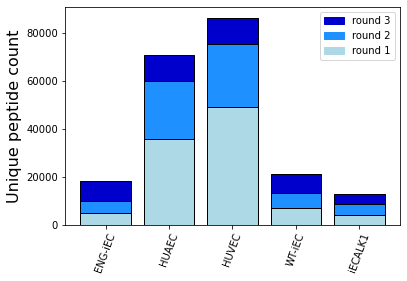

in-vivo


array(['Kidney-Xenograft', 'Liver-Xenograft', 'Tie2LF-Xenograft',
       'WT-Xenograft'], dtype=object)

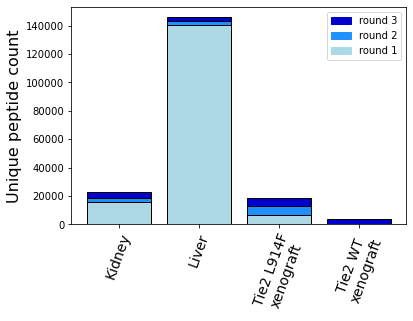

In [27]:
for et,etdf in vvtdf.groupby('experiment_type'):
    print(et)
    #for rnd,rdf in etdf.groupby('round'):
    display(etdf.cell_line.unique())
    t1 = etdf[etdf['round']==1].groupby('cell_line')['Protein'].count().reset_index()
    t1.sort_values('cell_line',inplace=True)
    t2 = etdf[etdf['round']==2].groupby('cell_line')['Protein'].count().reset_index()
    t2.sort_values('cell_line',inplace=True)
    t3 = etdf[etdf['round']==3].groupby('cell_line')['Protein'].count().reset_index()
    t3.sort_values('cell_line',inplace=True)

    plt.figure(figsize=(6, 4))
    if et == 'in-vivo':
        bar1 = plt.bar(t1['cell_line'],t1['Protein'],color='lightblue',bottom=[0,0,0],label=t1['Protein'],edgecolor='k')
        bar2 = plt.bar(t2['cell_line'],t2['Protein'],color='dodgerblue',bottom=t1['Protein'].values,edgecolor='k')
        bar3 = plt.bar(t3['cell_line'],t3['Protein'],color='mediumblue',bottom=list((t1.Protein + t2.Protein).values)+[0],edgecolor='k')
        
    else:
        bar1 = plt.bar(t1['cell_line'],t1['Protein'],color='lightblue',bottom=[0,0,0,0,0],label=t1['Protein'],edgecolor='k')
        bar2 = plt.bar(t2['cell_line'],t2['Protein'],color='dodgerblue',bottom=t1['Protein'].values,edgecolor='k')
        bar3 = plt.bar(t3['cell_line'],t3['Protein'],color='mediumblue',bottom=(t1.Protein + t2.Protein).values,edgecolor='k')

    top_bar = mpatches.Patch(color='mediumblue', label='round 3')
    middle_bar = mpatches.Patch(color='dodgerblue', label='round 2')
    bottom_bar = mpatches.Patch(color='lightblue', label='round 1')
    plt.legend(handles=[top_bar,middle_bar,bottom_bar])
    plt.ylabel('Unique peptide count',size=16)
    plt.xlabel('')
    plt.xticks(rotation=70)
    if et == 'in-vivo': plt.xticks(ticks=[0,1,2,3],labels=['Kidney','Liver','Tie2 L914F\nxenograft','Tie2 WT\nxenograft'],size=14)
    #plt.ylim(0,90000)
    #plt.xticks(ticks=[0,1,2,3,4],labels=['HUVEC','HUAEC','iEC WT','iEC ALK1 KO','iEC ENG KO'])
    plt.savefig('Figures/barplots_counts_per_4celllines_{}.png'.format(et),bbox_inches='tight')
    plt.show()

in-vitro


array(['ENG-iEC', 'HUAEC', 'HUVEC', 'WT-iEC', 'iECALK1'], dtype=object)

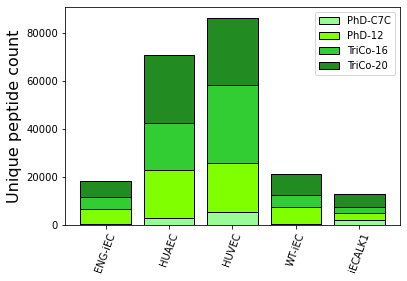

in-vivo


array(['Kidney-Xenograft', 'Liver-Xenograft', 'Tie2LF-Xenograft',
       'WT-Xenograft'], dtype=object)

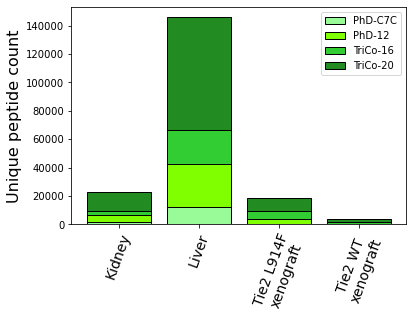

In [29]:
for et,etdf in vvtdf.groupby('experiment_type'):
    print(et)
    #for rnd,rdf in etdf.groupby('round'):
    display(etdf.cell_line.unique())
    t1 = etdf[etdf['library']==7].groupby('cell_line')['Protein'].count()
    t2 = etdf[etdf['library']==12].groupby('cell_line')['Protein'].count()
    t3 = etdf[etdf['library']==16].groupby('cell_line')['Protein'].count()
    t4 = etdf[etdf['library']==20].groupby('cell_line')['Protein'].count()
    t14= pd.concat([t1,t2,t3,t4],axis=1)
    t14.columns = ['7','12','16','20']
    t14.fillna(0,inplace=True)
    #break
    
    plt.figure(figsize=(6, 4))
    bar1 = plt.bar(t14.index,t14['7'],color='palegreen',label='PhD-C7C',edgecolor='k')    
    bar2 = plt.bar(t14.index,t14['12'],color='chartreuse',bottom=t14['7'],label='PhD-12',edgecolor='k')
    bar3 = plt.bar(t14.index,t14['16'],color='limegreen',bottom=t14['7']+t14['12'],label='TriCo-16',edgecolor='k')
    bar4 = plt.bar(t14.index,t14['20'],color='forestgreen',bottom=t14['7']+t14['12']+t14['16'],label='TriCo-20',edgecolor='k')
    
    plt.legend()
    plt.ylabel('Unique peptide count',size=16)
    plt.xlabel('')
    plt.xticks(rotation=70)
    if et == 'in-vivo': plt.xticks(ticks=[0,1,2,3],labels=['Kidney','Liver','Tie2 L914F\nxenograft','Tie2 WT\nxenograft'],size=14)
    #plt.ylim(0,90000)
    #plt.xticks(ticks=[0,1,2,3,4],labels=['HUVEC','HUAEC','iEC WT','iEC ALK1 KO','iEC ENG KO'])
    plt.savefig('Figures/barplots_counts_per_cellline_librarysplit_{}.png'.format(et),bbox_inches='tight')
    plt.show()

# make Venn diagramms

In [9]:
mydf0 = pd.read_csv('all_NGS_data_combined.csv',sep=',')

In [10]:
#remove unwanted samples from dataset #kidney and liver samples
#mydf_11 = mydf0[~mydf0['fraction'].str.contains('Kidney|Liver')].copy()
mydf_11 = mydf0[mydf0['fraction'] != 'ND'].copy()

C:\Users\khnd877\Anaconda3\envs\py36\lib\site-packages\matplotlib_venn\_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")
C:\Users\khnd877\Anaconda3\envs\py36\lib\site-packages\matplotlib_venn\_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")
C:\Users\khnd877\Anaconda3\envs\py36\lib\site-packages\matplotlib_venn\_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")
C:\Users\khnd877\Anaconda3\envs\py36\lib\site-packages\matplotlib_venn\_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")
C:\Users\khnd877\Anaconda3\envs\py36\lib\site-packages\matplotlib_venn\_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")
C:\Users\khnd877\AppData\Local\Temp\ipykernel_3532\2325183184.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pypl

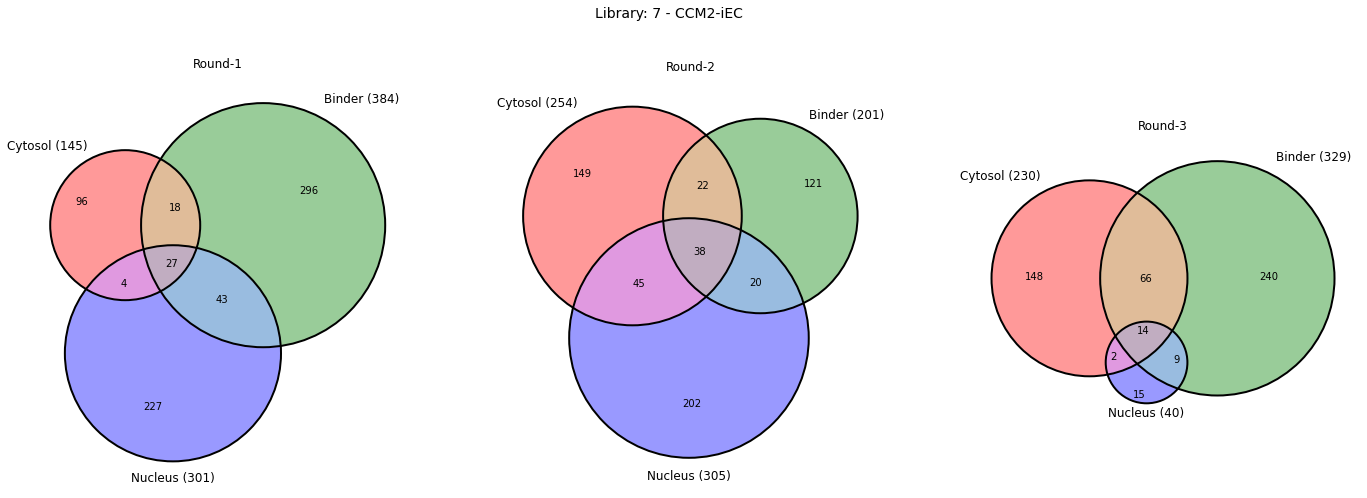

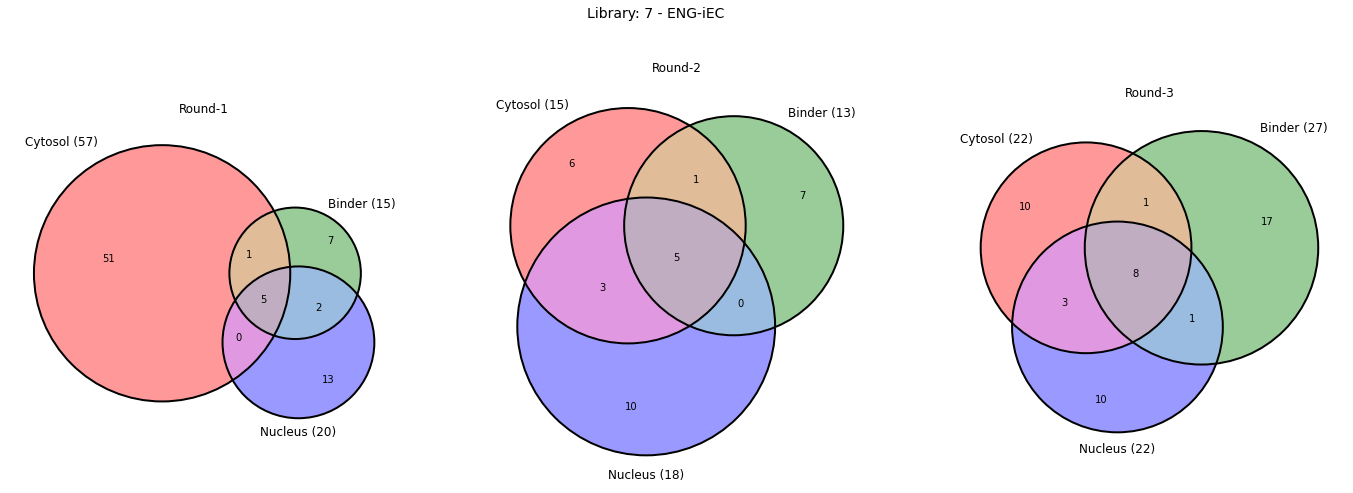

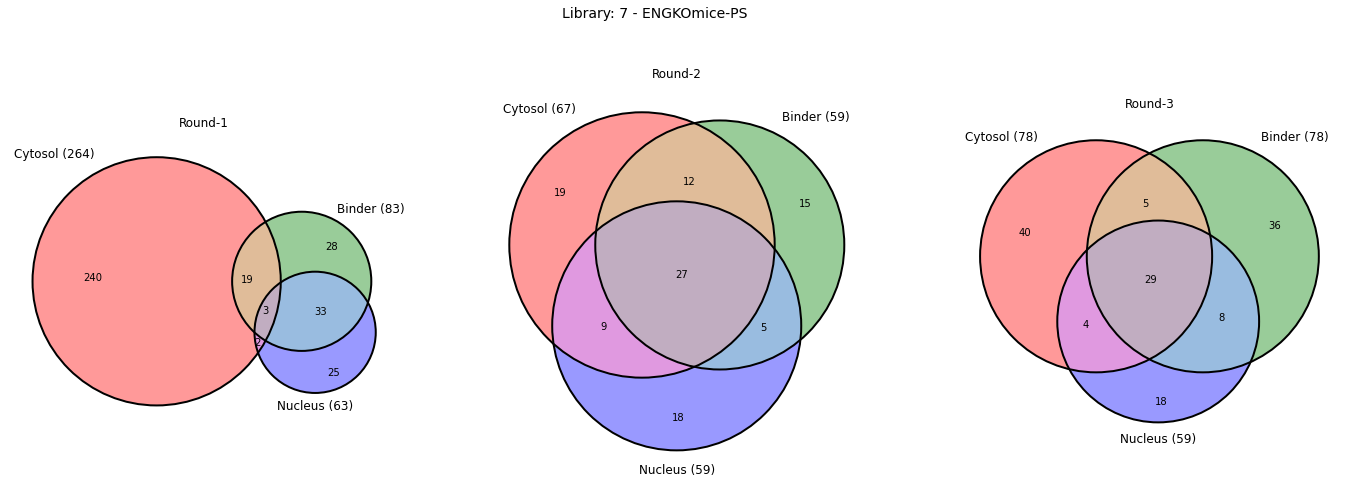

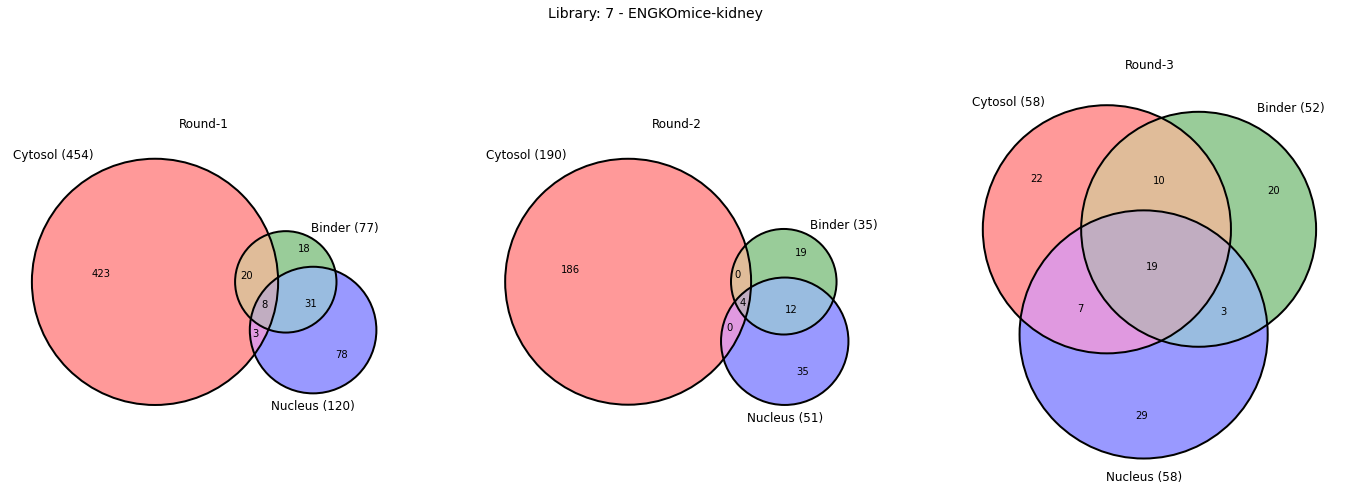

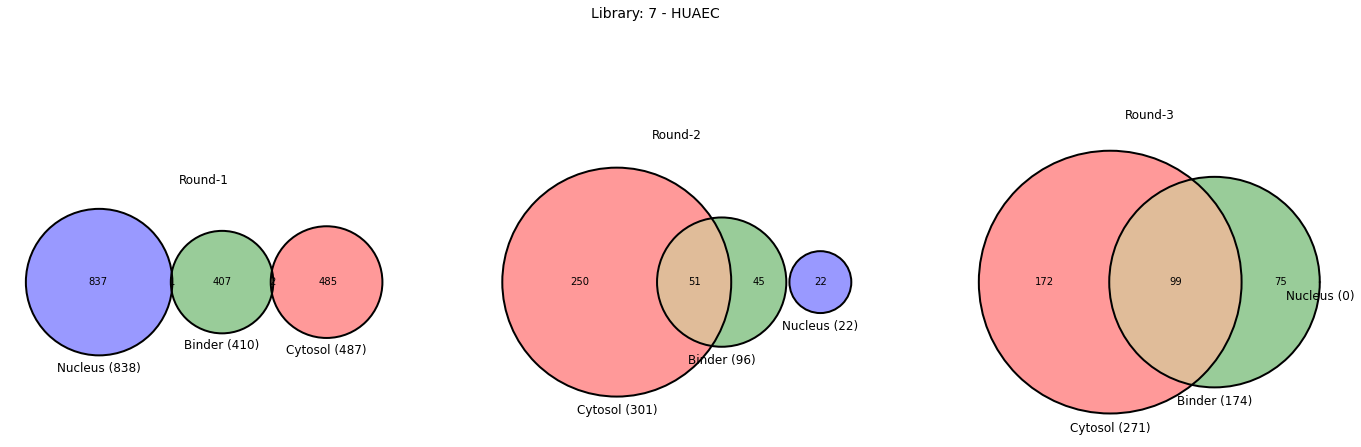

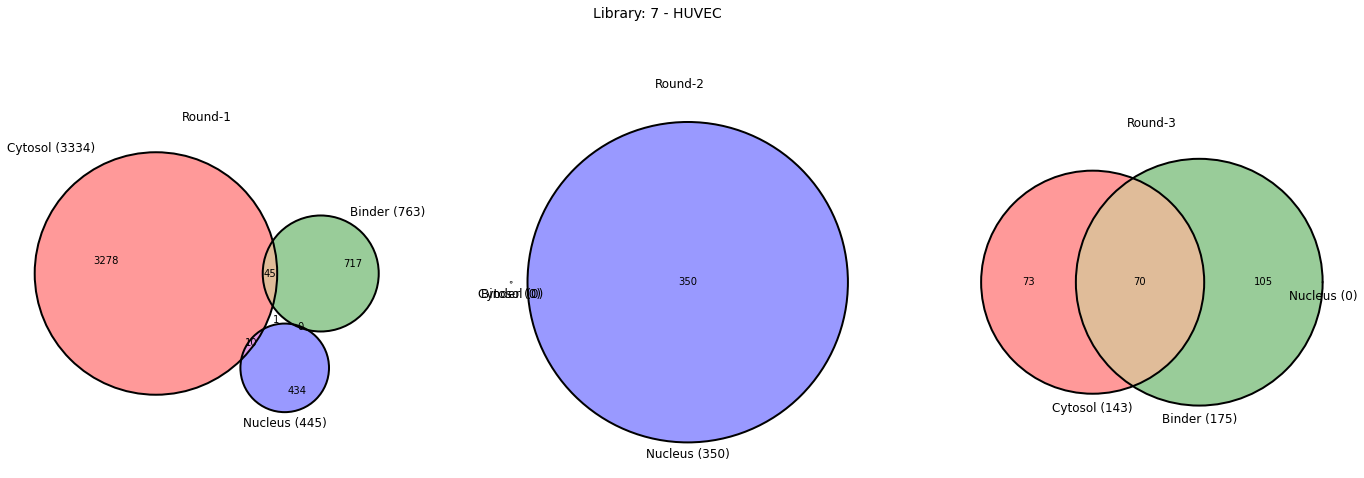

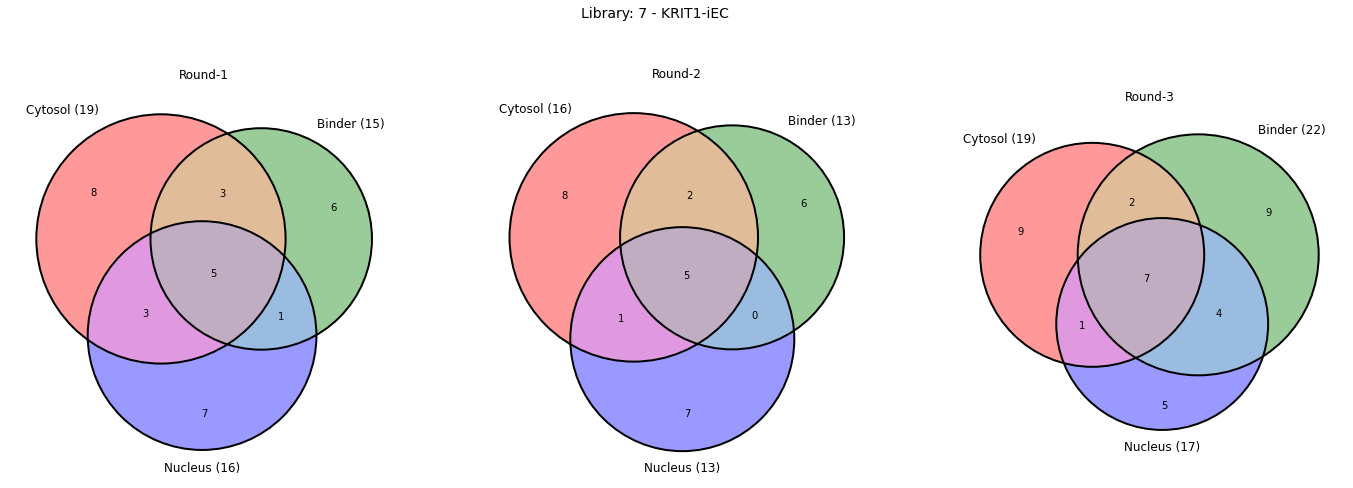

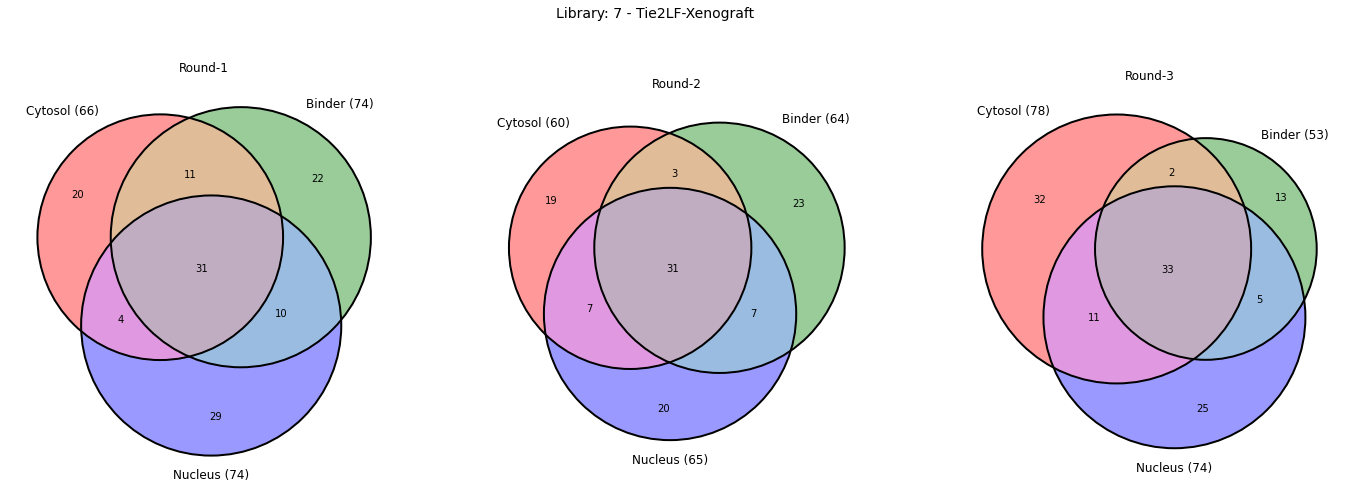

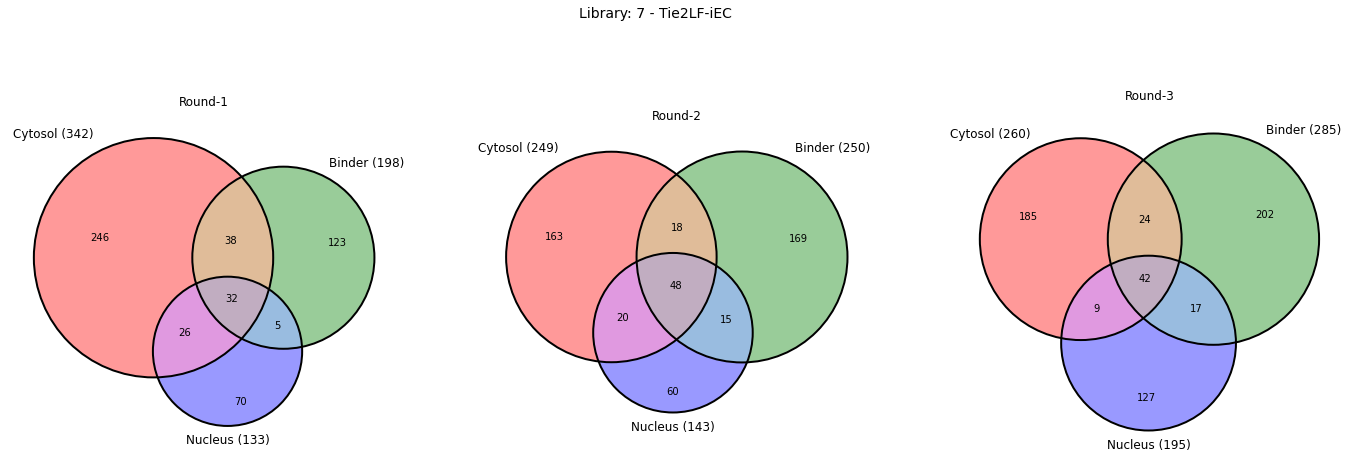

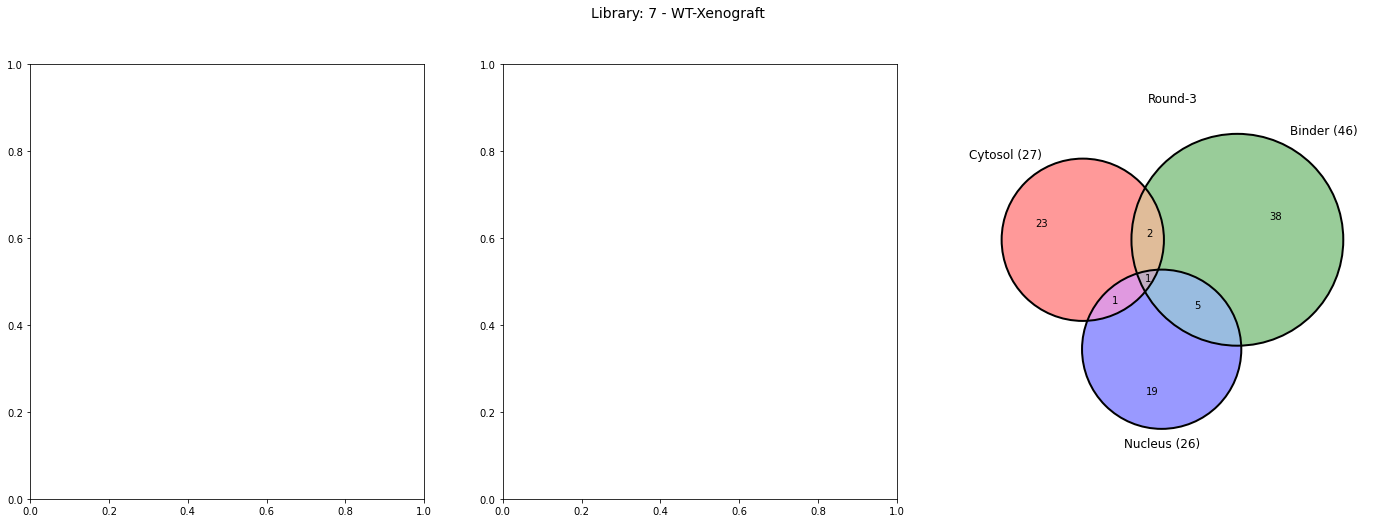

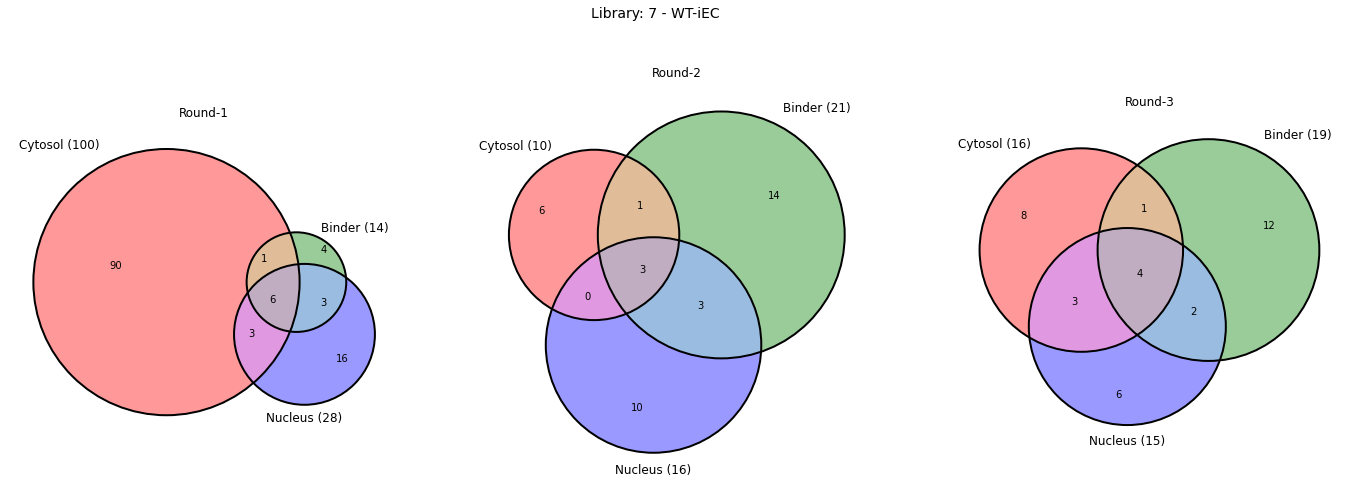

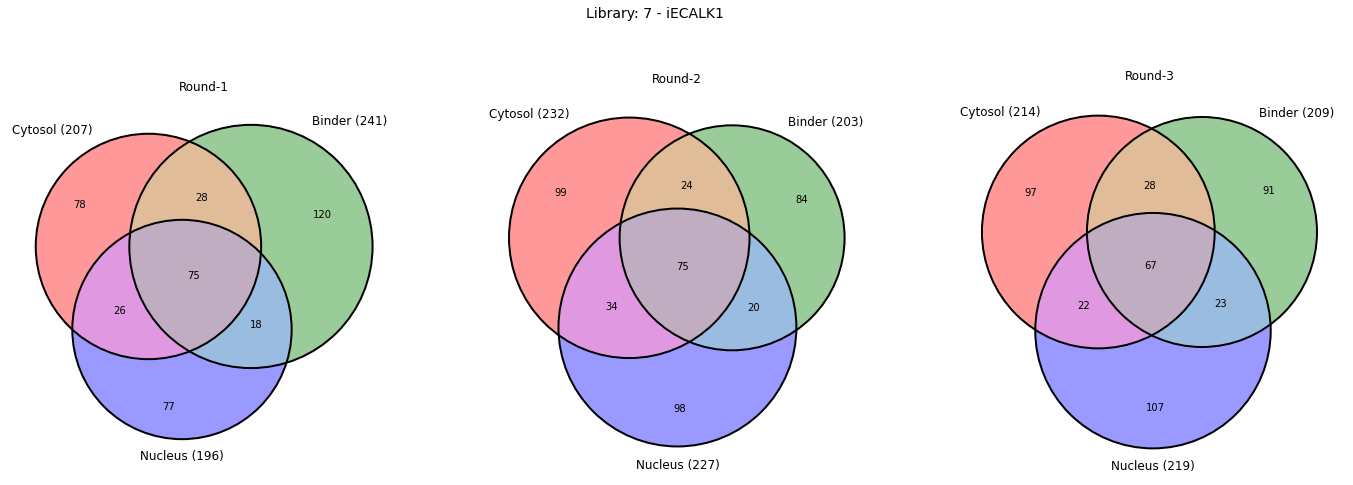

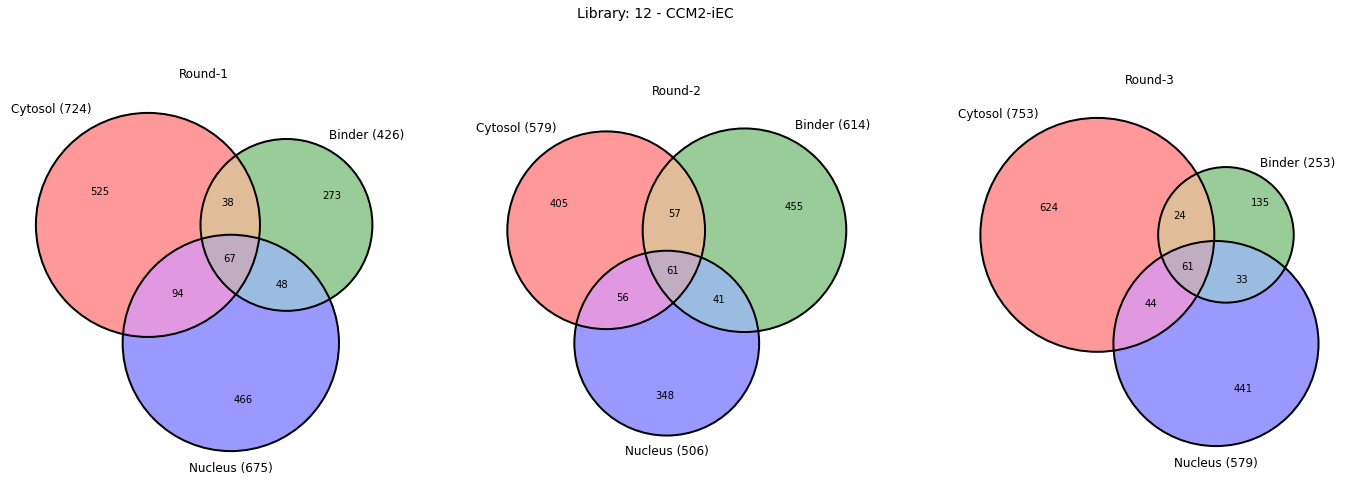

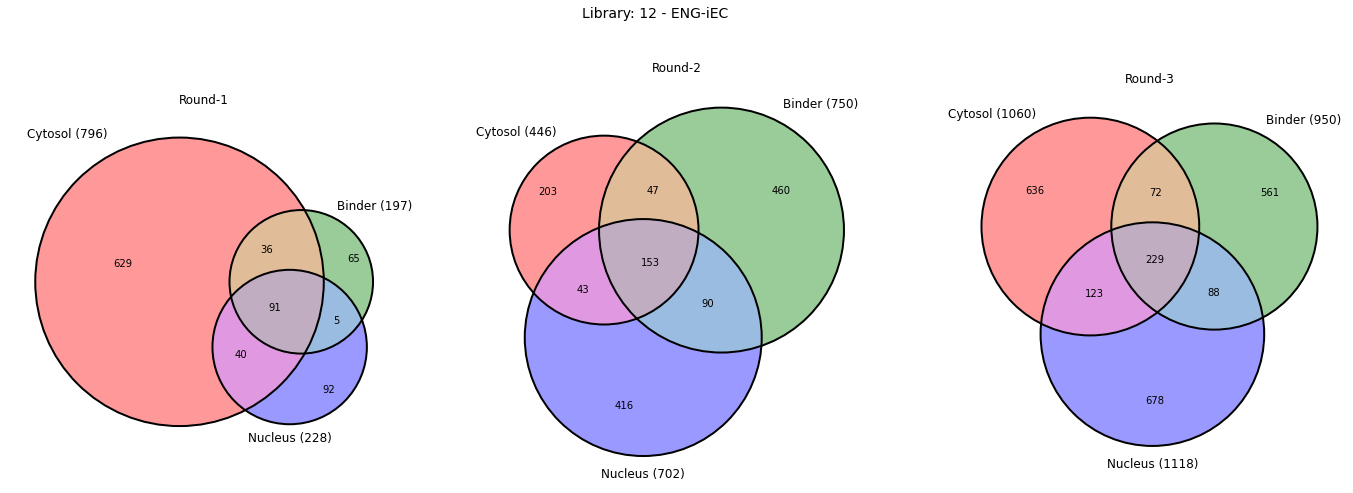

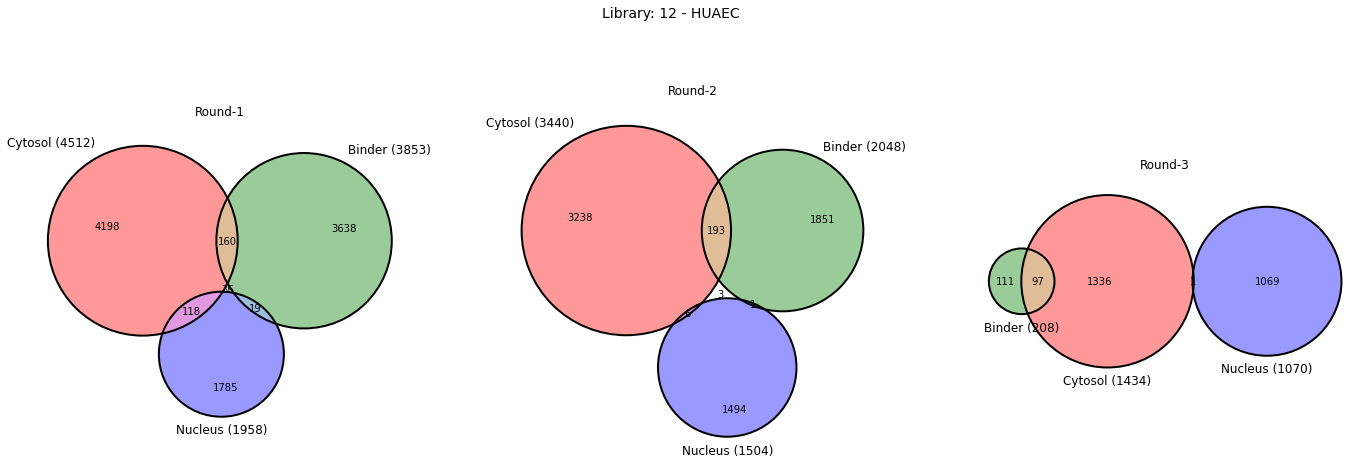

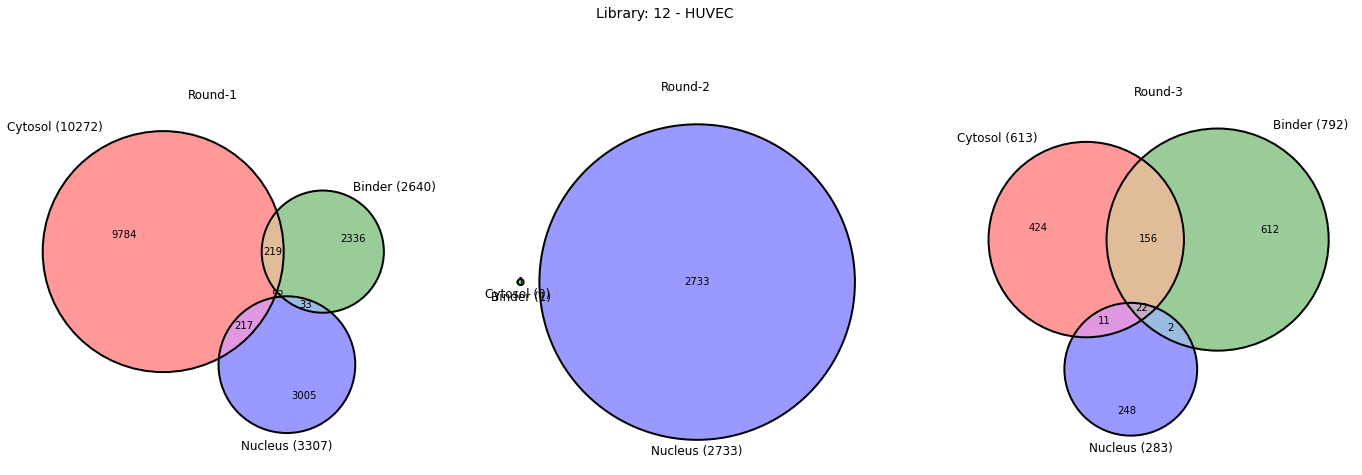

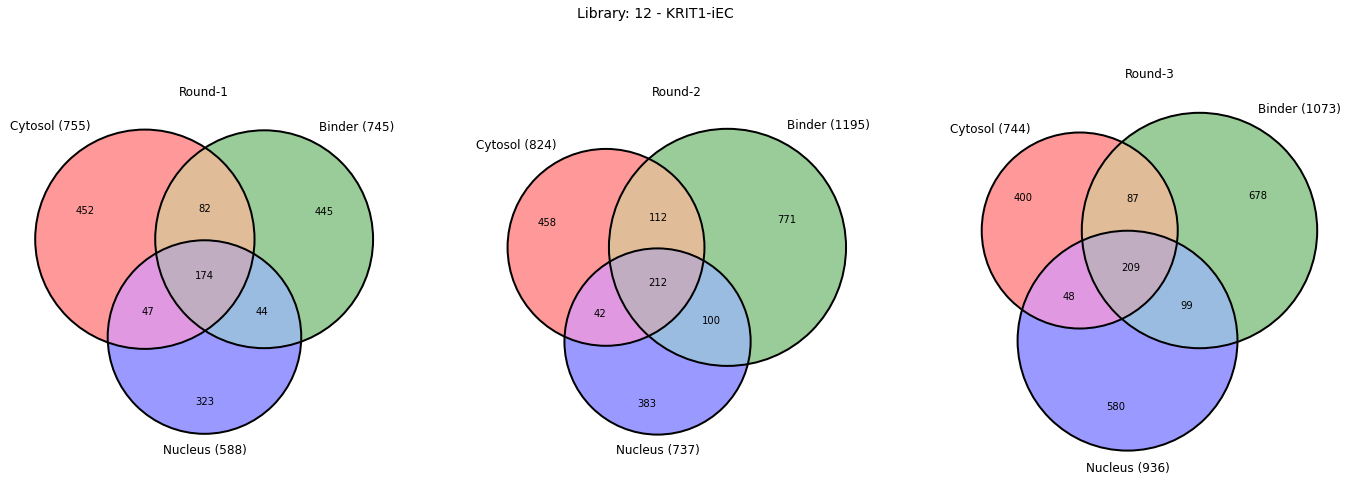

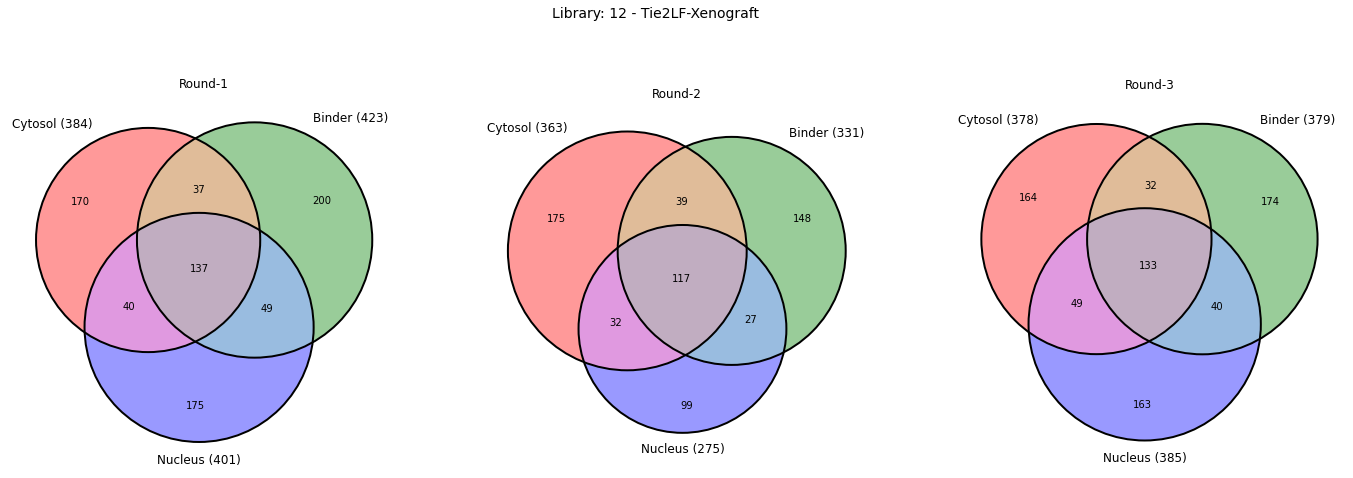

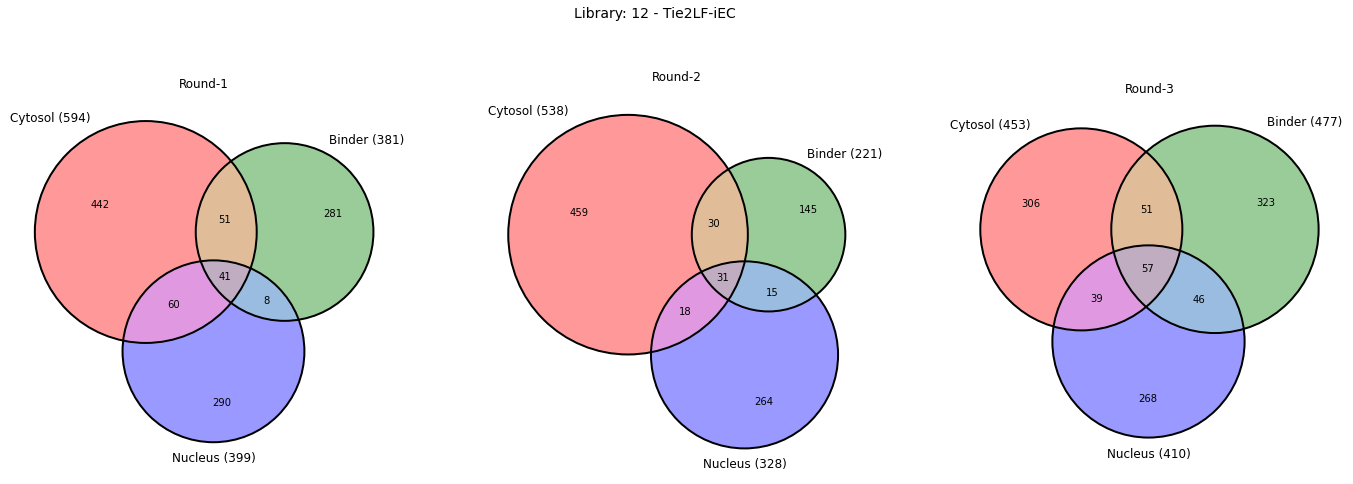

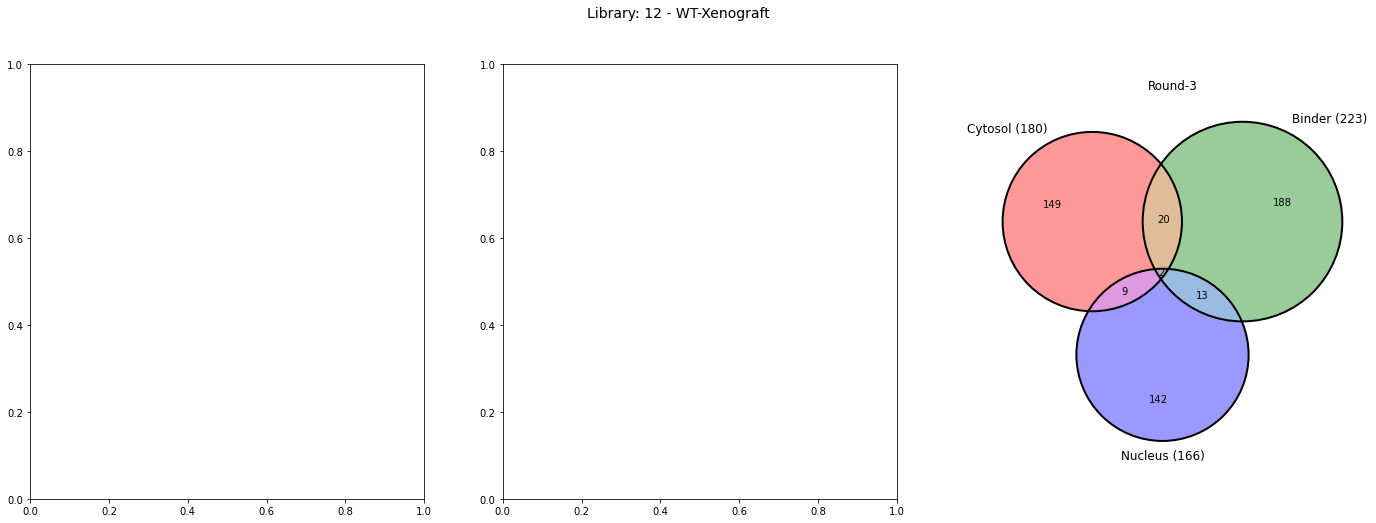

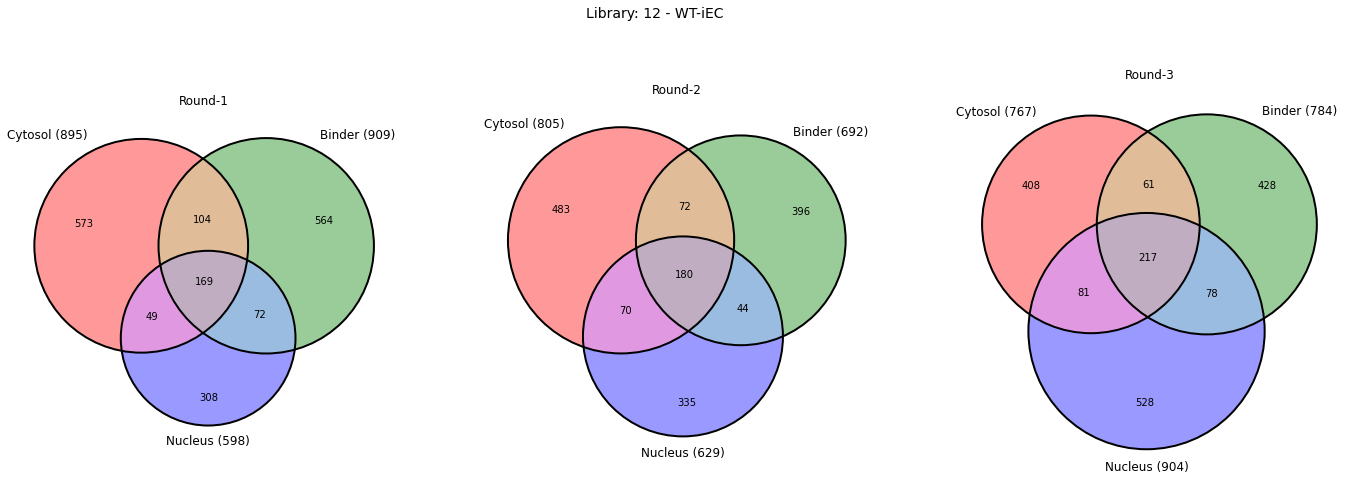

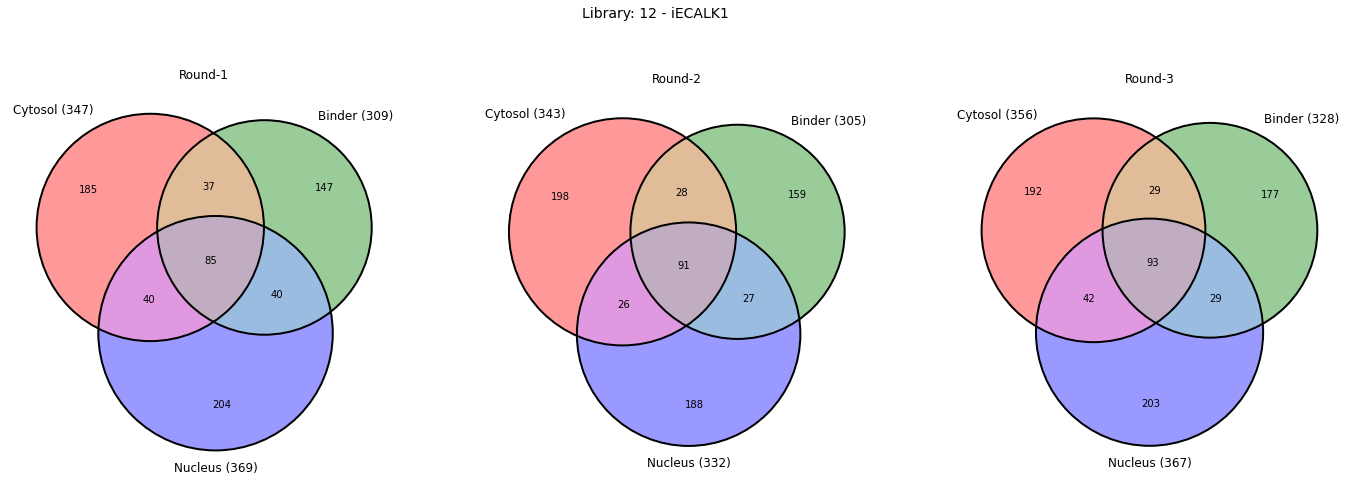

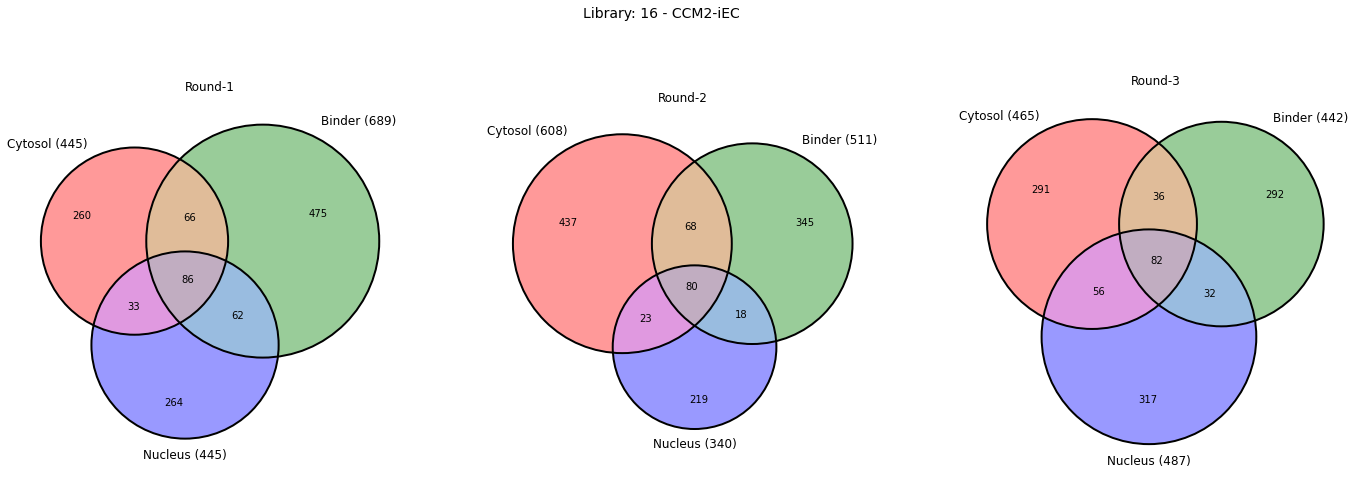

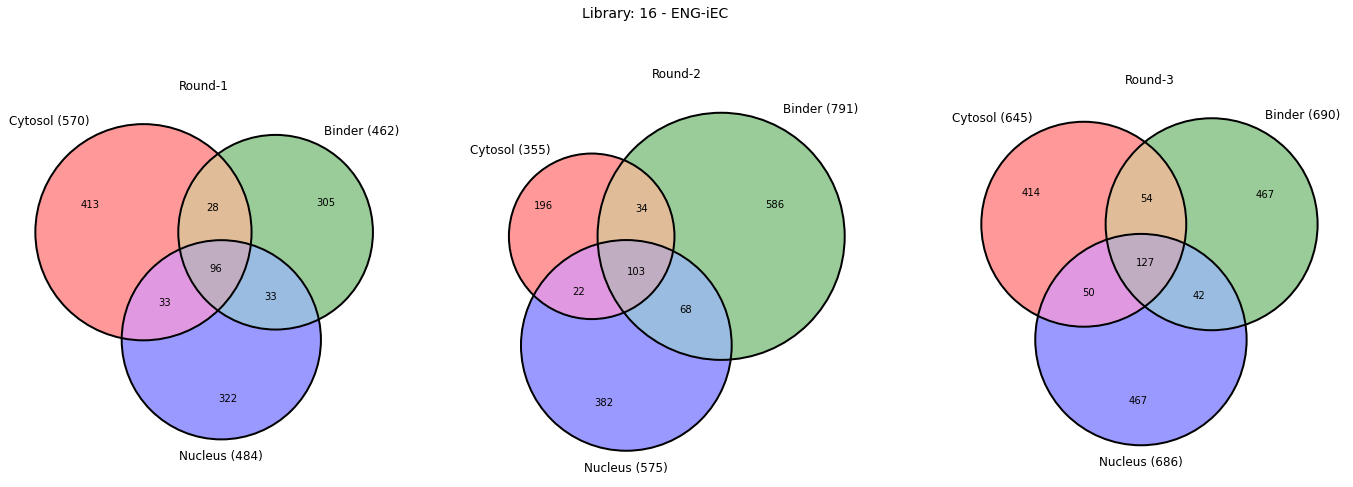

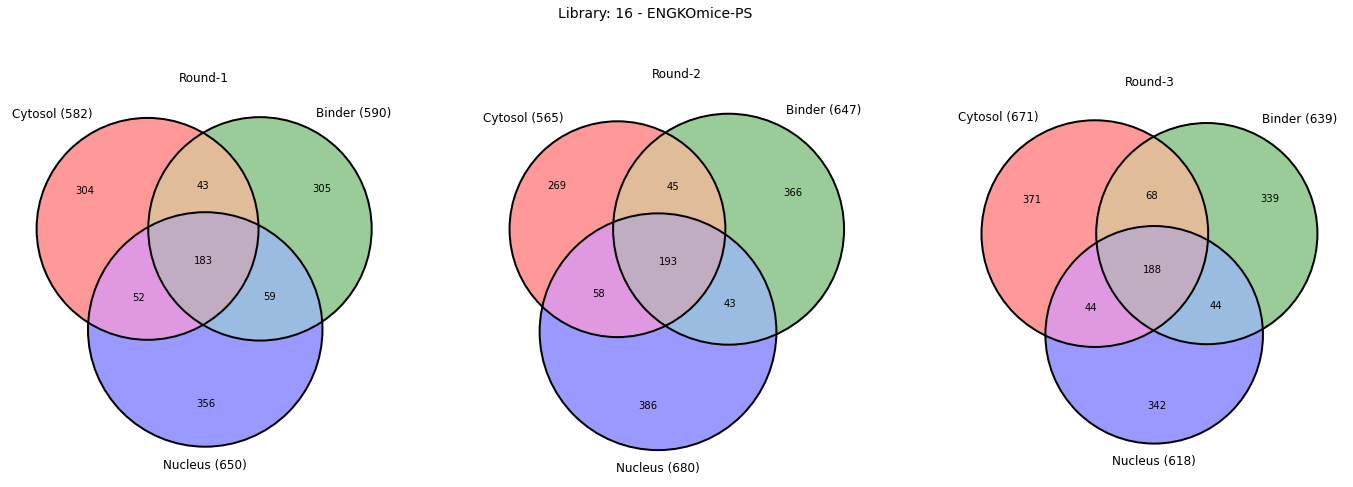

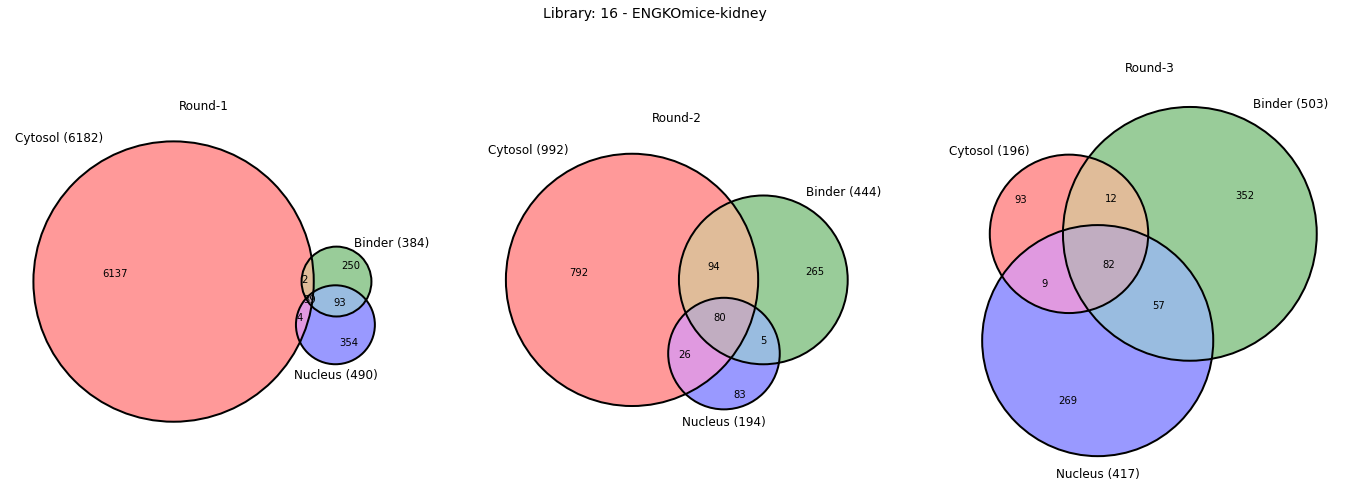

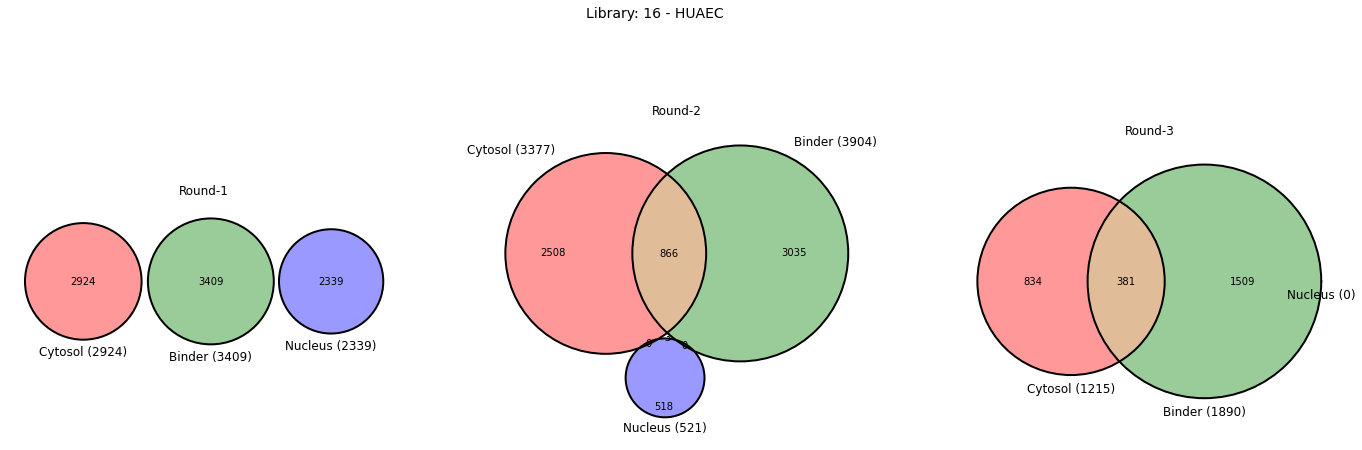

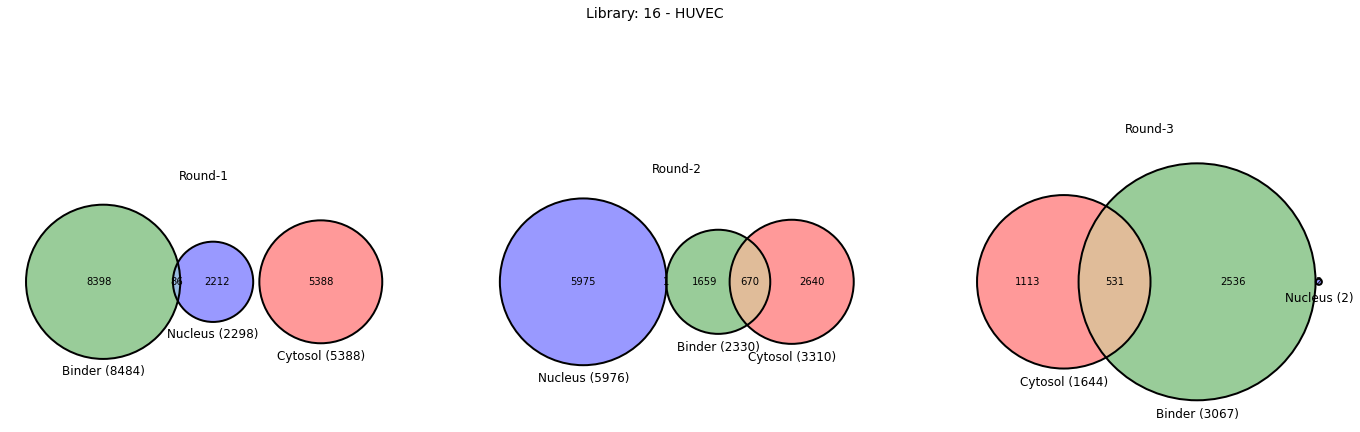

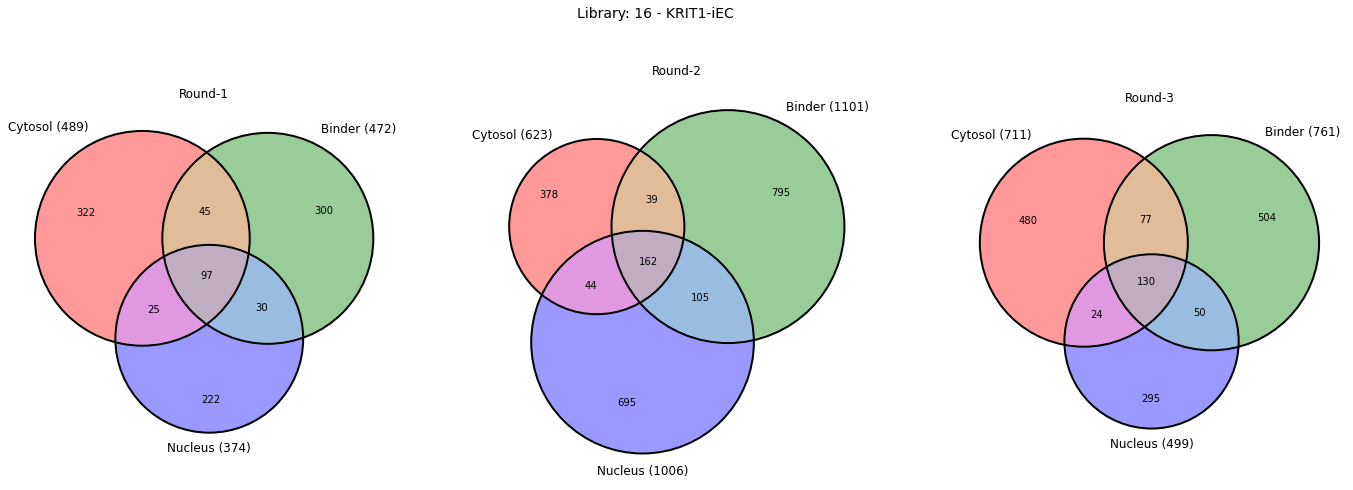

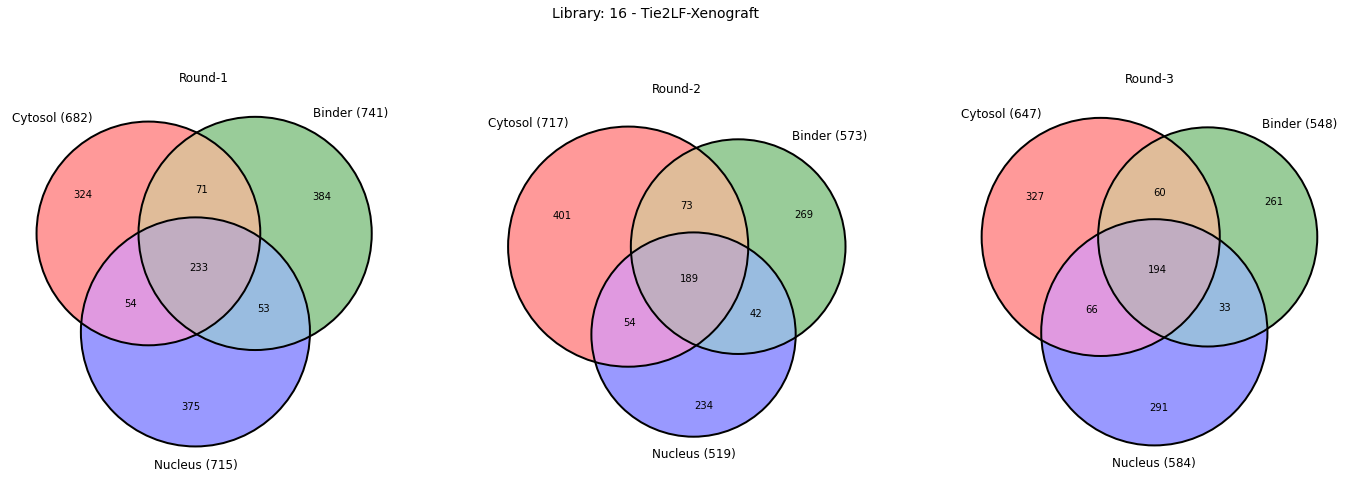

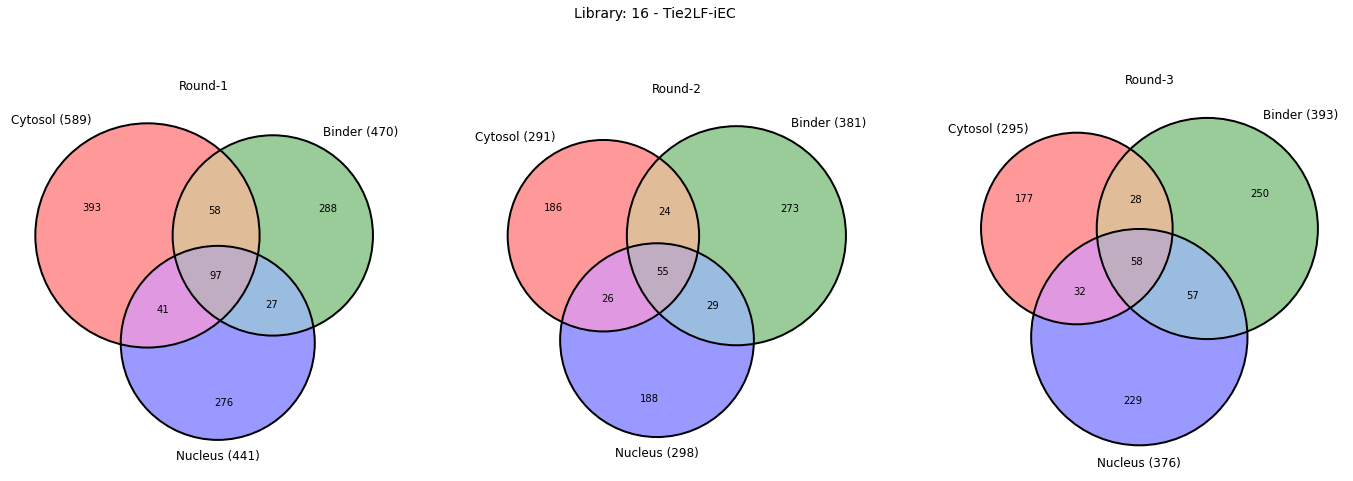

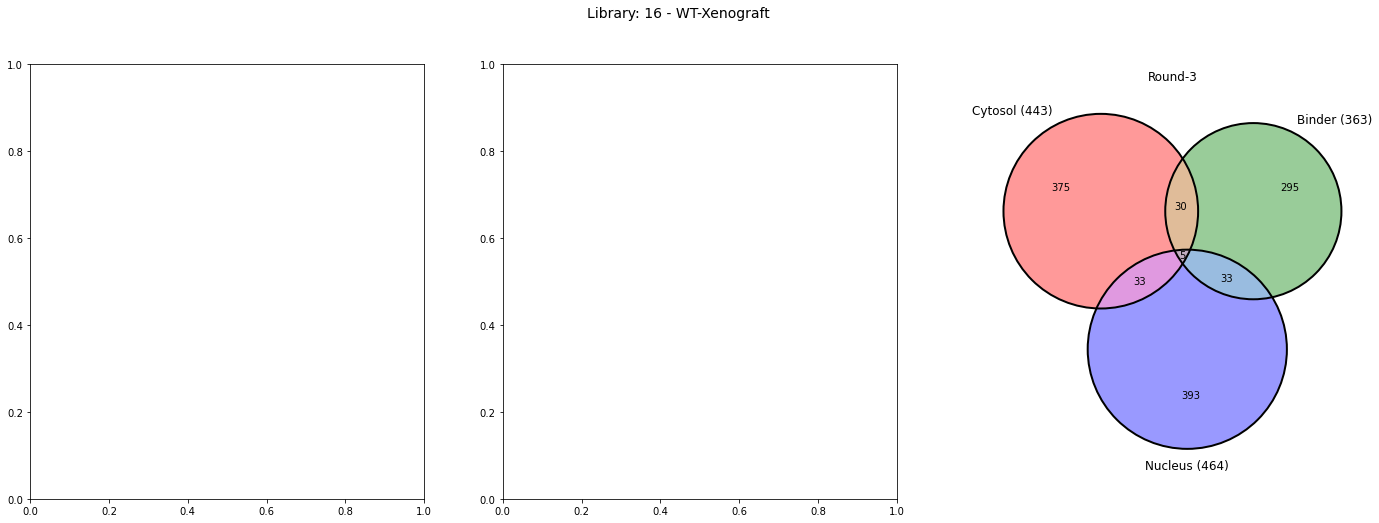

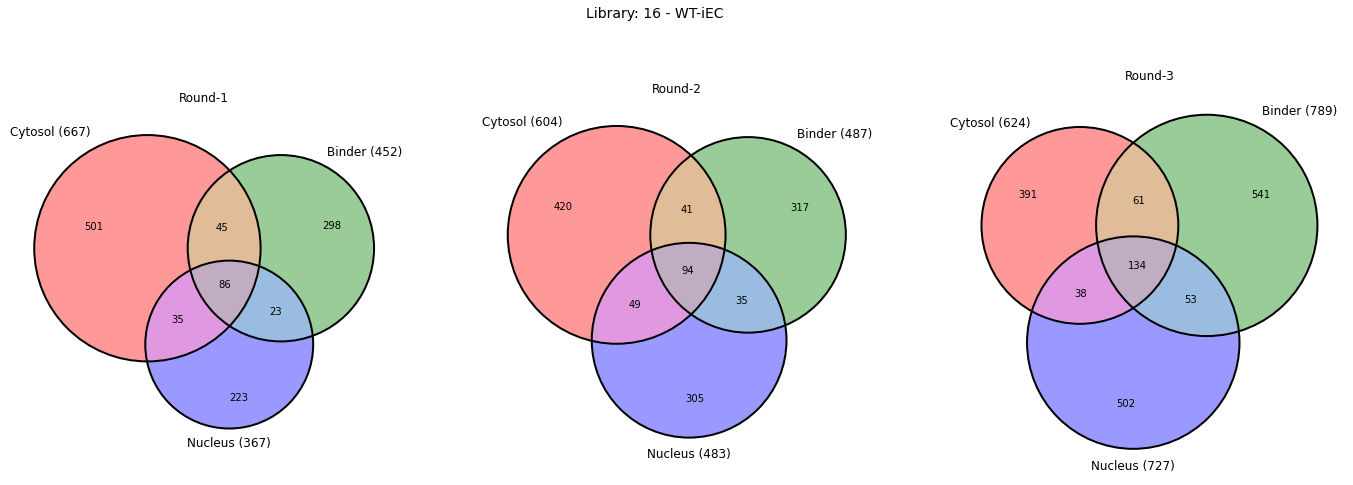

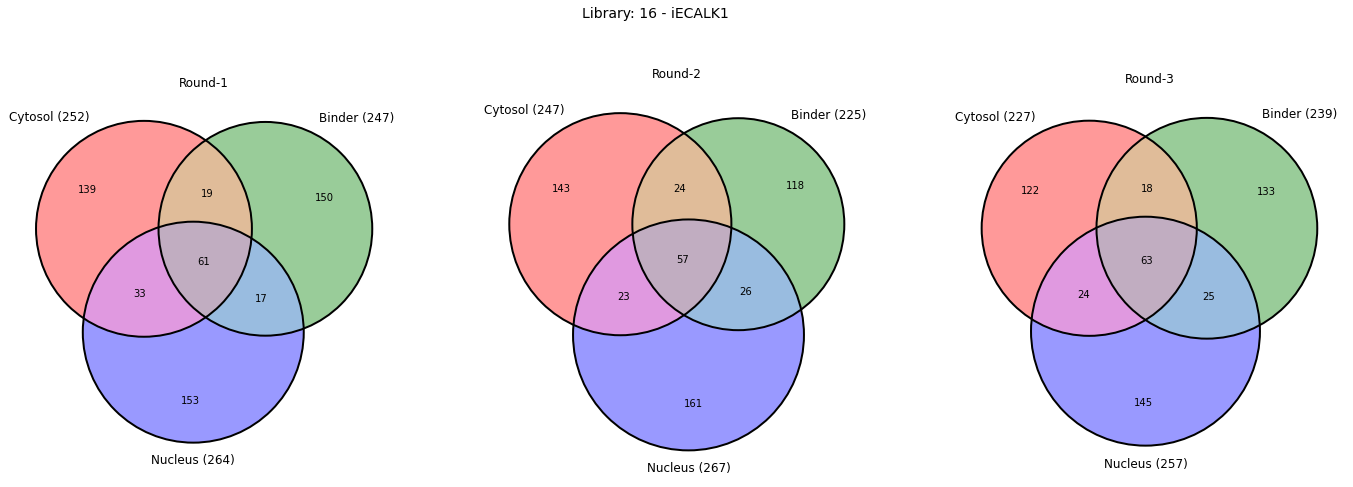

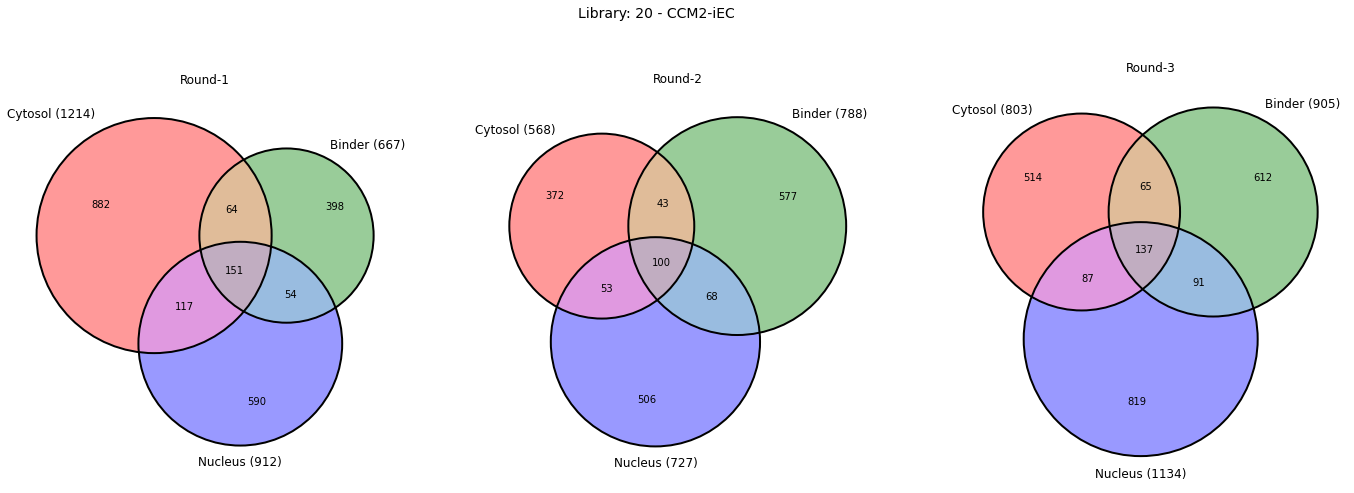

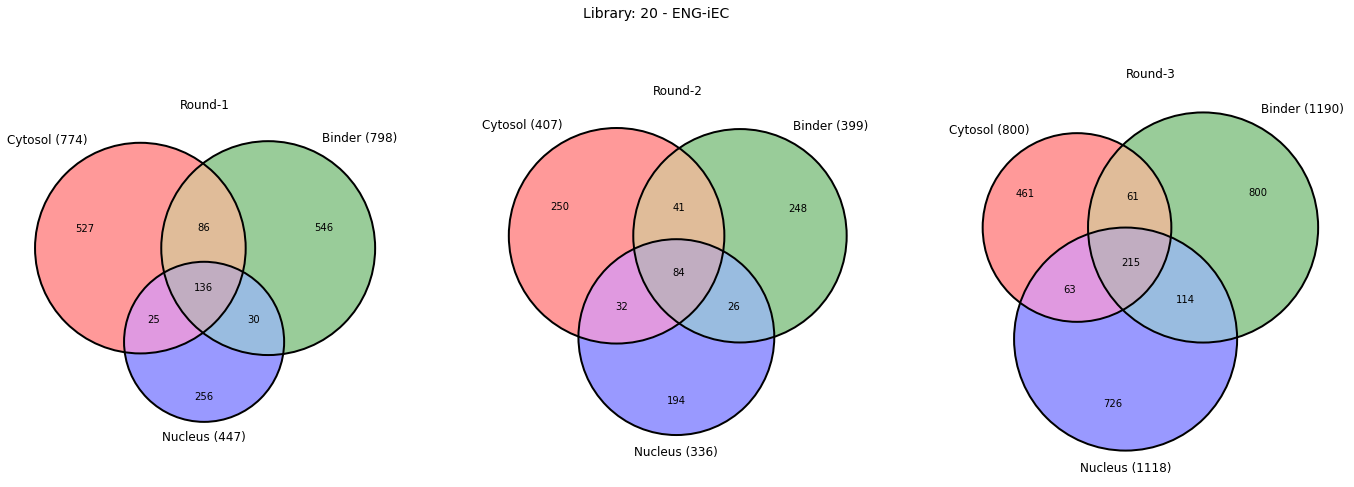

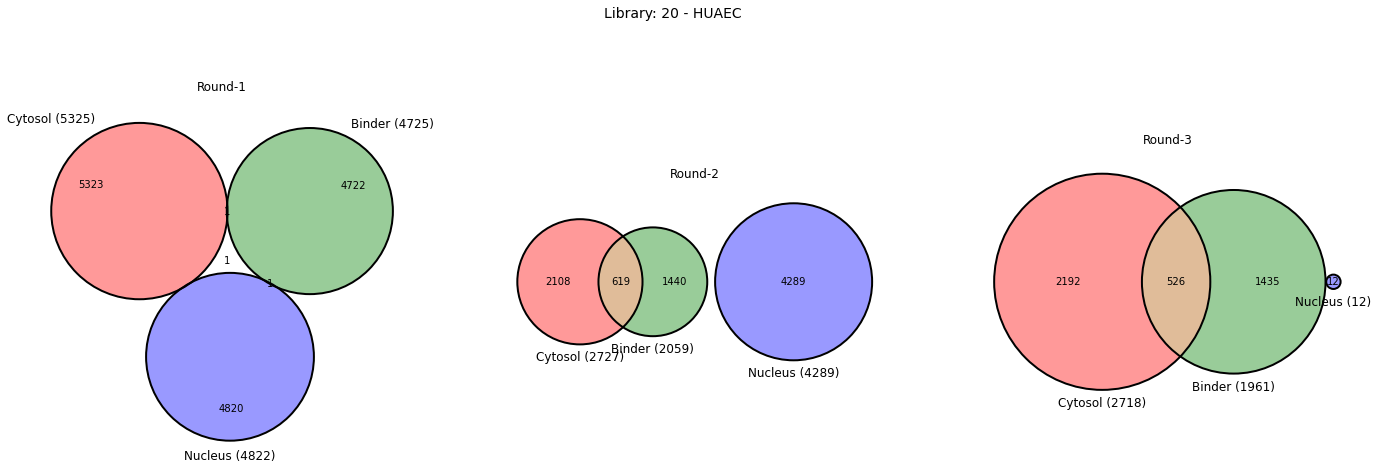

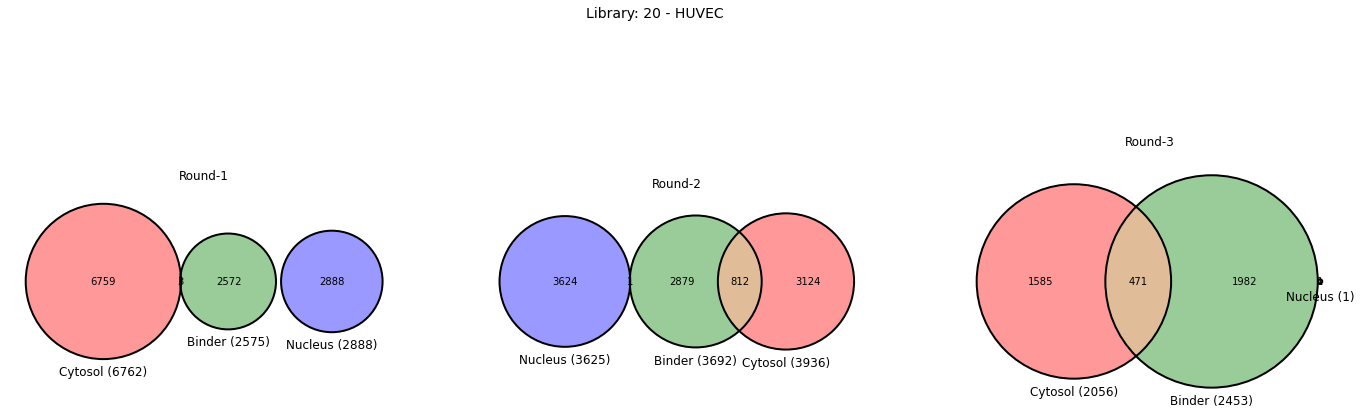

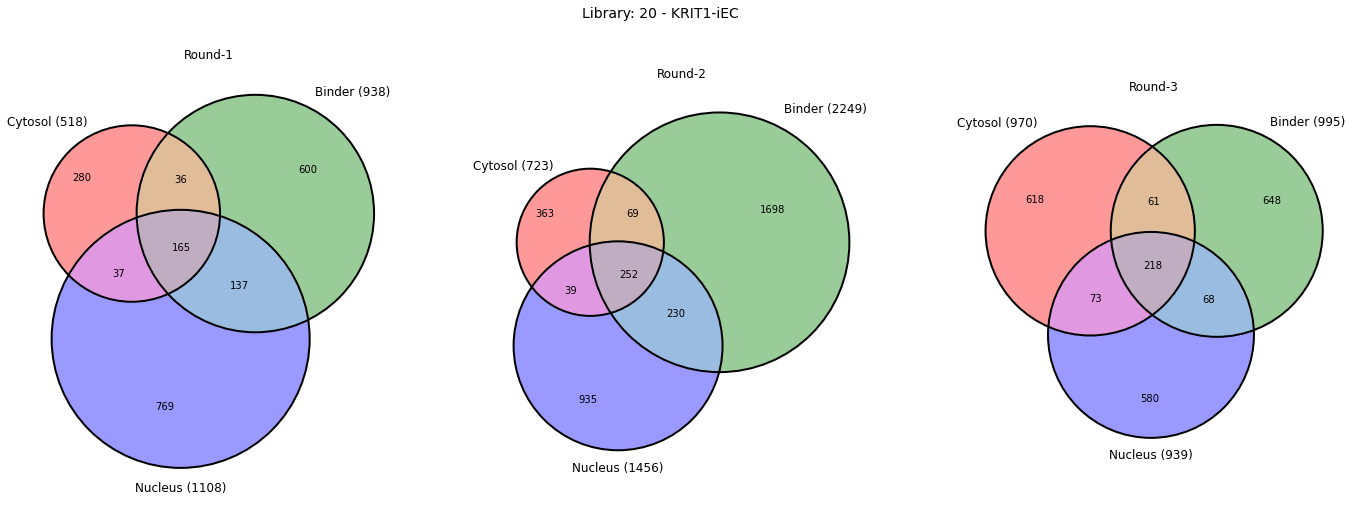

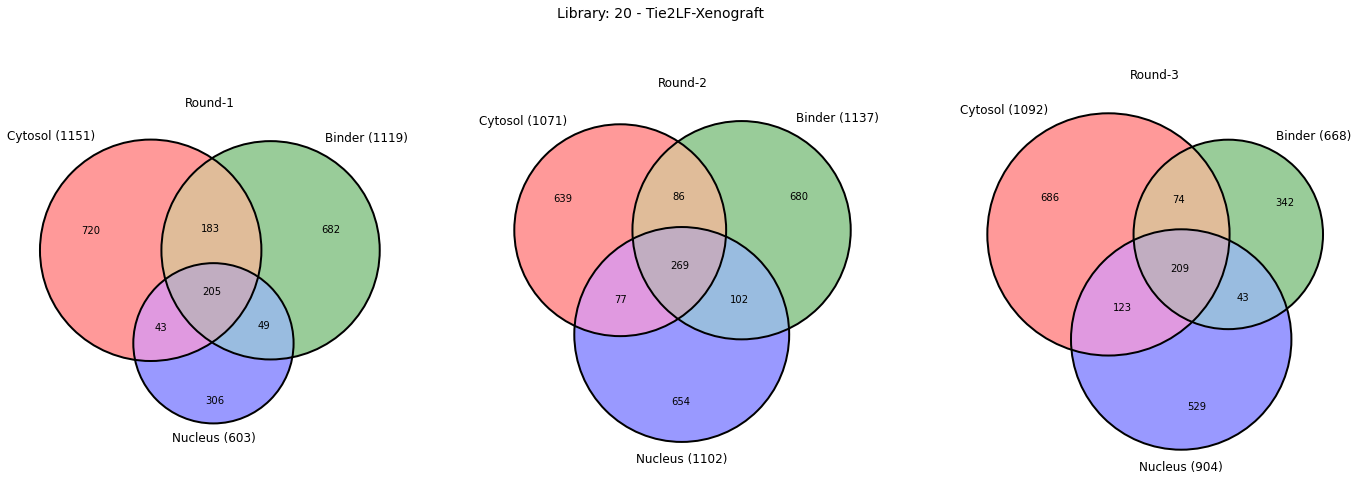

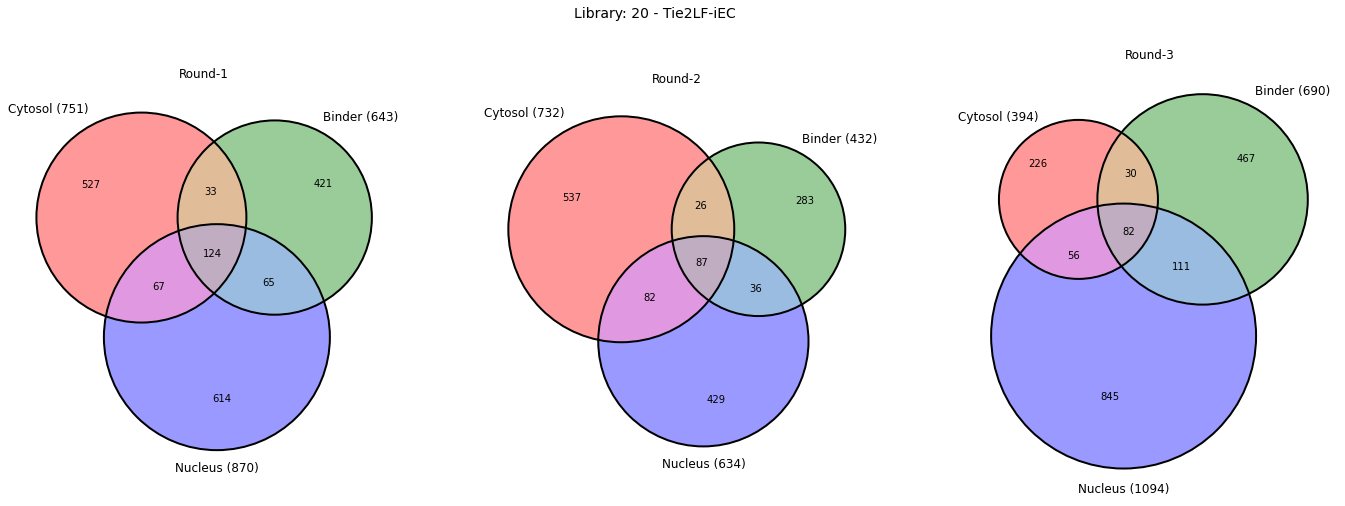

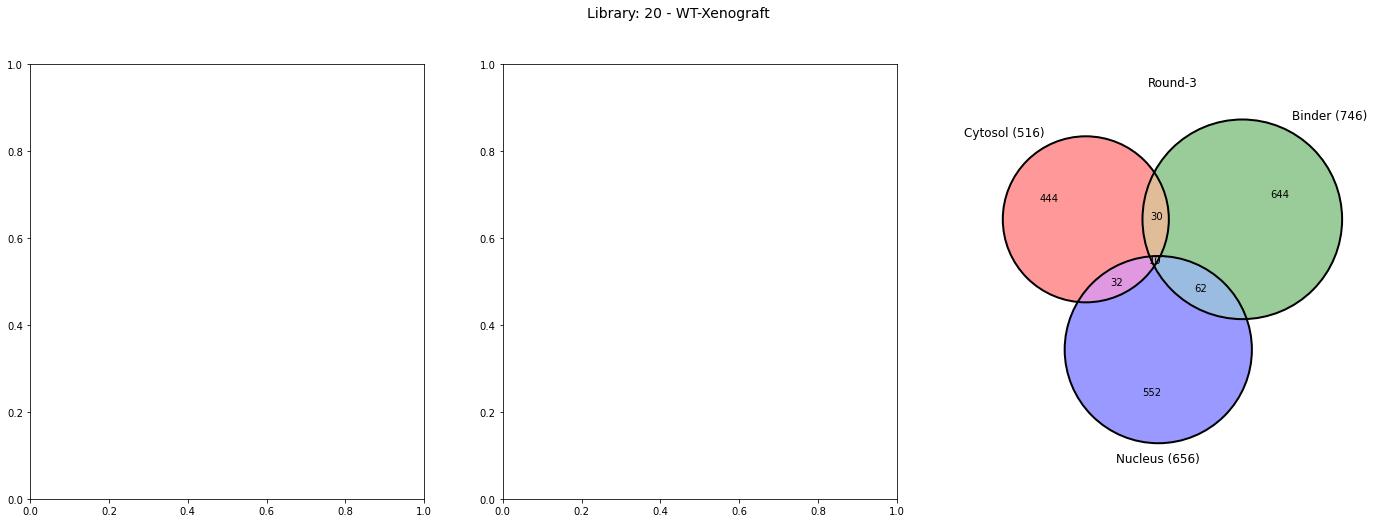

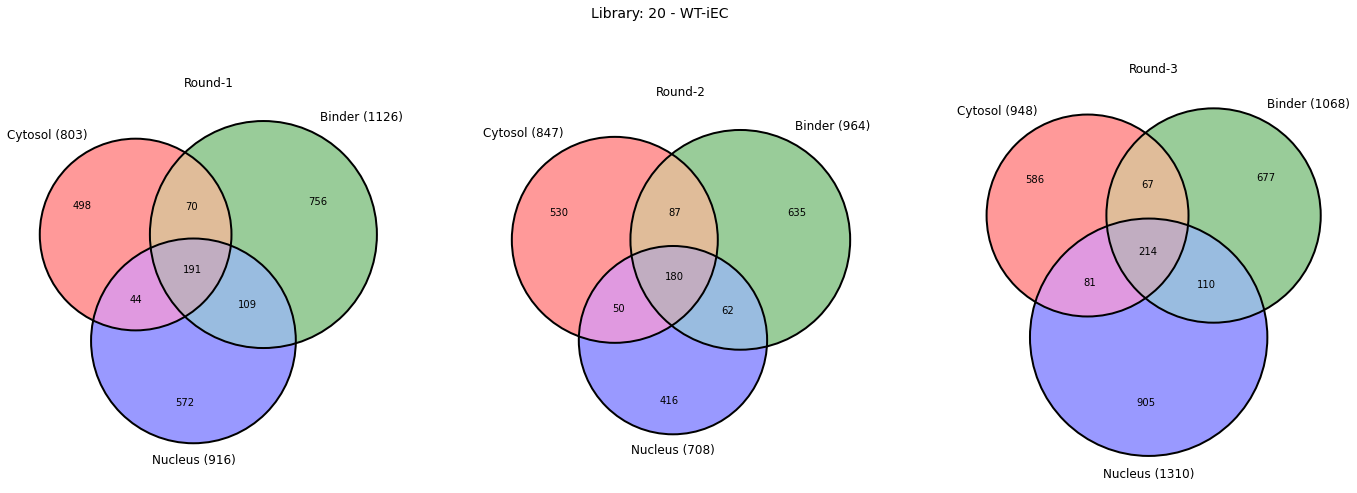

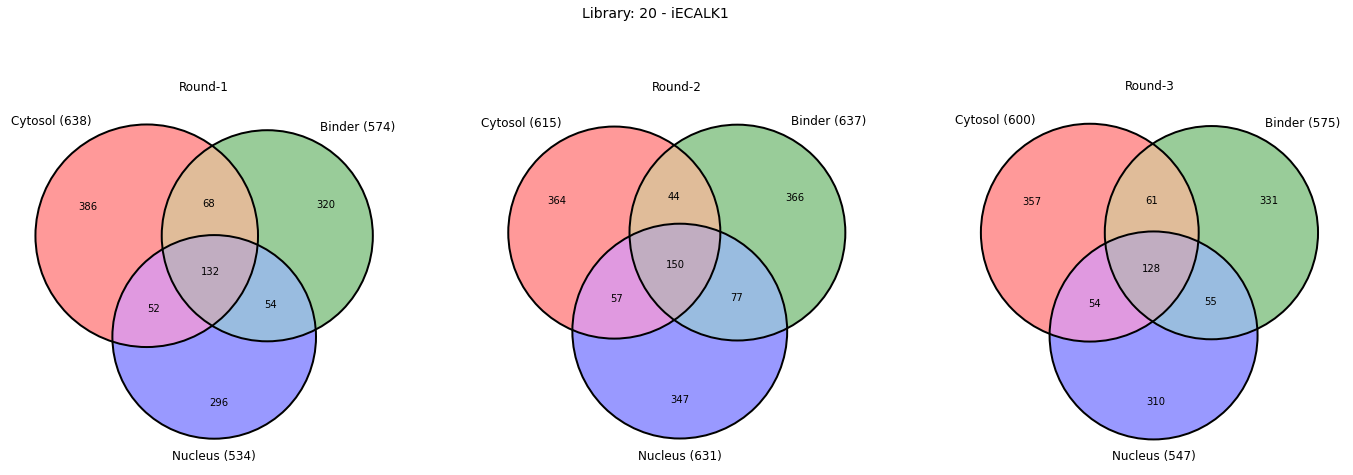

In [12]:
# make venn diagramms for each cell line and library
for g, df in mydf_11.groupby(['library','cell_line']):
    fig, axes = plt.subplots(1, 3, figsize=(24,8),facecolor='w')
    lib = g[0]
    Cl = g[1]
    fig.suptitle('Library: {} - {}'.format(lib,Cl),fontsize=14)
    for rnd,df2 in df.groupby('round'):
        fc = set(df2[df2['fraction'].str.contains('C')]['Protein'])
        fd = set(df2[df2['fraction'].str.contains('D')]['Protein'])
        fn = set(df2[df2['fraction'].str.contains('N')]['Protein'])
        labs = ['{} ({})'.format('Cytosol', len(fc)),'{} ({})'.format('Binder', len(fd)),'{} ({})'.format('Nucleus', len(fn))]
        
        r = int(rnd)
        axes[r-1].set_title('Round-{}'.format(r),fontsize=12)
        venn3([fc,fd,fn],set_labels=labs, ax=axes[r-1])
        venn3_circles([fc,fd,fn], ax=axes[r-1])
    
    #plt.savefig('Fractional_analysis_Venn_diagrams/{}-{}.png'.format(Cl,lib), bbox_inches='tight')
    #plt.close()

In [7]:
# now make venn diagrams to compare kideny and liver
dfKL = mydf0[mydf0['fraction'] == 'ND'].copy()

In [8]:
# make venn diagramms for each cell line and library
for g, df in dfKL.groupby(['library']):
    print(g)
    #continue
    fig, axes = plt.subplots(1, 3, figsize=(24,8),facecolor='w')
    lib = g #library
    fig.suptitle('Library: {}'.format(lib),fontsize=14)
    for r,df2 in df.groupby('round'):
        rnd = int(r)
        fl = set(df2[df2['cell_line'].str.contains('Liver')]['Protein'])
        fk = set(df2[df2['cell_line'].str.contains('Kidney')]['Protein'])
        labs = ['{} ({})'.format('Liver', len(fl)),'{} ({})'.format('Kidney', len(fk))]
        
        axes[rnd-1].set_title('Round-{}'.format(rnd),fontsize=12)
        venn2([fl,fk],set_labels=labs, ax=axes[rnd-1])
        venn2_circles([fl,fk], ax=axes[rnd-1])
    
    plt.savefig('Fractional_analysis_Venn_diagrams/Liver_kidney_{}-{}.png'.format('Xenograft',lib), bbox_inches='tight')
    plt.close()
    #break

7
12
16
20


# make venndiagramm of xenograft WT vs Tie2

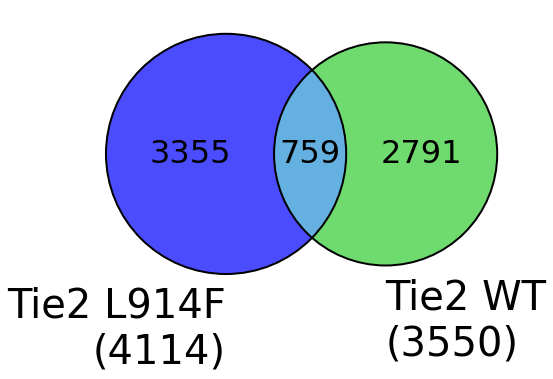

In [14]:
t2df = mydf0[mydf0['cell_line']=='Tie2LF-Xenograft']
wtdf = mydf0[mydf0['cell_line']=='WT-Xenograft']
# make venndiagramm of xenograft WT vs Tie2
#continue
fig, axes = plt.subplots(1, 1, figsize=(8,6),facecolor='w')
#fig.suptitle('Tie2 vs WT Xenograft',fontsize=12)

rnd = 3
ft = set(t2df[t2df['round']==3]['Protein'])
fw = set(wtdf[wtdf['round']==3]['Protein'])
labs = ['{}\n({})'.format('Tie2 L914F', len(ft)),'{}\n({})'.format('Tie2 WT', len(fw))]

#axes.set_title('Tie2 L914F vs Tie2 WT xenograft',fontsize=32)
out = venn2([ft,fw],set_labels=labs, set_colors=('blue', 'limegreen'), alpha = 0.7)
out2 = venn2_circles([ft,fw])


for text in out.set_labels:
    text.set_fontsize(40)
for text in out.subset_labels:
    text.set_fontsize(32)
    
tie2_exclusive = ft.difference(fw)
plt.savefig('Figures/Venn_Tie2_WT.png', bbox_inches='tight')
#plt.close()
#break

# make vendiagramm of liver vs kidney

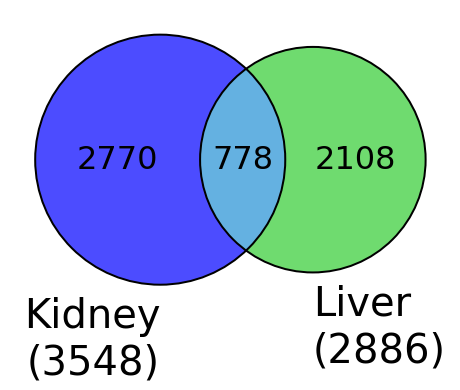

In [15]:
dfKL = mydf0[mydf0['fraction'] == 'ND'].copy()
dfKL2 = dfKL[dfKL['round']==3].copy()
# make venndiagramm of Liver vs kidney
fig, axes = plt.subplots(1, 1, figsize=(8,6),facecolor='w')
#fig.suptitle('Tie2 vs WT Xenograft',fontsize=12)
ft = set(dfKL2[dfKL2['cell_line'].str.contains('Kidney')]['Protein'])
fw = set(dfKL2[dfKL2['cell_line'].str.contains('Liver')]['Protein'])
labs = ['{}\n({})'.format('Kidney', len(ft)),'{}\n({})'.format('Liver', len(fw))]

#axes.set_title('Kidney vs Liver',fontsize=12)
out= venn2([ft,fw],set_labels=labs, set_colors=('blue', 'limegreen'), alpha = 0.7)
venn2_circles([ft,fw])

for text in out.set_labels:
    text.set_fontsize(40)
for text in out.subset_labels:
    text.set_fontsize(32)
plt.savefig('Figures/Venn_Liver_kidney.png', bbox_inches='tight')
#plt.close()
#break

# compare kidney, liver and tie2 xenograft

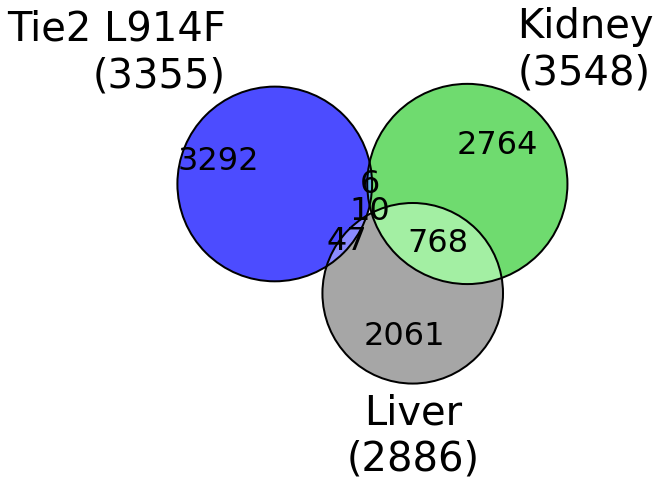

In [33]:
t2df = mydf0[mydf0['cell_line']=='Tie2LF-Xenograft']
kdf = mydf0[mydf0['cell_line']=='Kidney-Xenograft']
ldf = mydf0[mydf0['cell_line']=='Liver-Xenograft']

fig, axes = plt.subplots(1, 1, figsize=(8,8),facecolor='w')
#fig.suptitle('Library: {} - {}'.format(lib,Cl),fontsize=14)

fk = set(kdf[kdf['round']==3]['Protein'])
fl = set(ldf[ldf['round']==3]['Protein'])
labs = ['{}\n({})'.format('Tie2 L914F', len(tie2_exclusive)),'{}\n({})'.format('Kidney', len(fk)),'{}\n({})'.format('Liver', len(fl))]

#axes.set_title('Unique peptides found in kidney, liver, and Tie2',fontsize=14)
v1 = venn3([tie2_exclusive,fk,fl],set_labels=labs, set_colors=('blue', 'limegreen','grey'), alpha = 0.7)
v2 = venn3_circles([tie2_exclusive,fk,fl])

for text in v1.set_labels:
    text.set_fontsize(40)
for text in v1.subset_labels:
    text.set_fontsize(32)

tie2_exclusive2 = tie2_exclusive.difference(fk)
tie2_exclusive3 = tie2_exclusive2.difference(fl)
plt.savefig('Figures/Venn3_Tie2_kidney_liver.png', bbox_inches='tight')
#plt.close()

# break Tie2 down into fractions and compare overlap

In [35]:
#tie2_exclusive3
t2df = mydf0[mydf0['cell_line']=='Tie2LF-Xenograft']
t2_ex_df = t2df.set_index('Protein').loc[list(tie2_exclusive3)]
t2_ex_df3 = t2_ex_df[t2_ex_df['round']==3].copy()

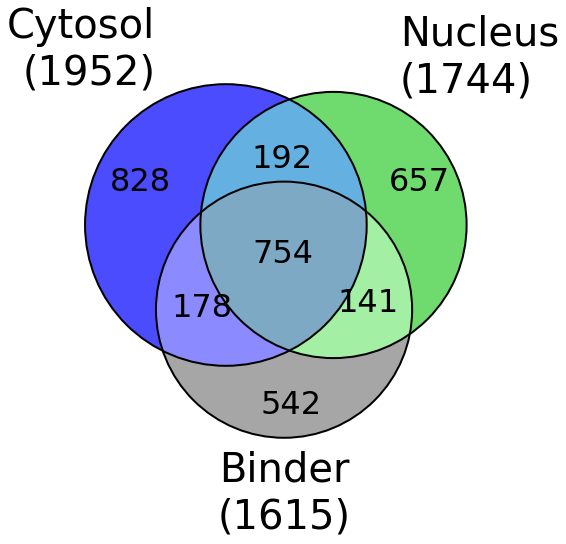

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(8,8),facecolor='w')
#fig.suptitle('Library: {} - {}'.format(lib,Cl),fontsize=14)

fc = set(t2_ex_df[t2_ex_df['fraction']=='Cytosol'].index)
fn = set(t2_ex_df[t2_ex_df['fraction']=='Nucleus'].index)
fd = set(t2_ex_df[t2_ex_df['fraction']=='Debris'].index)
labs = ['{}\n({})'.format('Cytosol', len(fc)),'{}\n({})'.format('Nucleus', len(fn)),'{}\n({})'.format('Binder', len(fd))]

#axes.set_title('Unique Tie2 peptides found in cellular fractions',fontsize=14)
v1 = venn3([fc,fn,fd],set_labels=labs, set_colors=('blue', 'limegreen','grey'), alpha = 0.7)
v2 = venn3_circles([fc,fn,fd])

for text in v1.set_labels:
    text.set_fontsize(40)
for text in v1.subset_labels:
    text.set_fontsize(32)
plt.savefig('Figures/Venn3_fractions.png', bbox_inches='tight')
#plt.close()

# see which proteins are most prominent in each fraction

('CCM2-iEC', '12')
21


Count  \
Protein                               
SQSKLPWSEGNWFGGGS     [3, 216, 198]   
SIECNMLRLQTKCGGGS            [1133]   
SALSDPHHKSIMTGGGS          [1, 635]   
SFANYPRFTPVTSGGGS             [398]   
SSSFGMSSKLISHGGGS          [1, 159]   
SHTNSNTLSLTFAGGGS             [418]   
SQEAWTGSGMAHAGGGS             [548]   
SSHYQGNHVDNKLGGGS  [541, 527, 1075]   
SQTSEPLEYHGGLGGGS             [589]   
SSTLSTDLWGCLPGGGS             [598]   
SVHAYPVCFSLLCGGGS             [201]   
SLNLTKLGTVSVNGGGS             [439]   
SDASKPPGWPSSHGGGS          [392, 1]   
SNSLEATTRDYIYGGGS     [2, 141, 553]   
STDPISYPARMSRGGGS     [658, 225, 2]   
SMPLRYPTQVTLDGGGS  [494, 188, 2395]   
SFSNDLTLRFSESGGGS             [299]   
SYALGRPSLQGPNGGGS    [296, 55, 229]   
SSHYQGNHVDNNLGGGS   [210, 282, 365]   
SSSFGMSSQLISHGGGS        [234, 508]   
SFSTDYAWTAEATGGGS  [1540, 463, 397]   

                                                          Percentage  \
Protein                                                                
SQSKLPWSEGNWFGGGS           [0.001968, 0.1781829999999999, 0.125938]   
SIECNMLRLQTKCGGGS                               [0.7430789999999998]   
SALSDPHHKSIMTGGGS                               [0.000656, 0.403892]   
SFANYPRFTPVTSGGGS                               [0.2531480000000001]   
SSSFGMSSKLISHGGGS                     [0.000656, 0.1311619999999999]   
SHTNSNTLSLTFAGGGS                                         [0.265868]   
SQEAWTGSGMAHAGGGS                               [0.3485560000000001]   
SSHYQGNHVDNKLGGGS  [0.3548159999999999, 0.434734, 0.6837540000000...   
SQTSEPLEYHGGLGGGS                               [0.3746350000000001]   
SSTLSTDLWGCLPGGGS                               [0.3921989999999999]   
SVHAYPVCFSLLCGGGS                               [0.1658089999999999]   
SLNLTKLGTVSVNGGGS                                         [0.279226]   
SDASKPPGWPSSHGGGS                               [0.257094, 0.000825]   
SNSLEATTRDYIYGGGS           [0.001312, 0.116314, 0.3517350000000001]   
STDPISYPARMSRGGGS           [0.4315509999999999, 0.185608, 0.001272]   
SMPLRYPTQVTLDGGGS  [0.3239919999999999, 0.155085, 1.5233380000000...   
SFSNDLTLRFSESGGGS                               [0.1960999999999999]   
SYALGRPSLQGPNGGGS  [0.1941319999999999, 0.0453709999999999, 0.145...   
SSHYQGNHVDNNLGGGS                      [0.13773, 0.232628, 0.232158]   
SSSFGMSSQLISHGGGS           [0.1534689999999999, 0.4190600000000001]   
SFSTDYAWTAEATGGGS                     [1.010009, 0.381939, 0.252511]   

                                     fraction     seq_count         rank  
Protein                                                                   
SQSKLPWSEGNWFGGGS  [Nucleus, Debris, Cytosol]     [1, 4, 6]  [85, 5, 17]  
SIECNMLRLQTKCGGGS                   [Nucleus]          [15]          [1]  
SALSDPHHKSIMTGGGS          [Nucleus, Cytosol]        [1, 8]     [190, 2]  
SFANYPRFTPVTSGGGS                   [Cytosol]          [11]          [8]  
SSSFGMSSKLISHGGGS           [Nucleus, Debris]        [1, 3]     [446, 8]  
SHTNSNTLSLTFAGGGS                   [Cytosol]          [16]          [7]  
SQEAWTGSGMAHAGGGS                   [Cytosol]          [13]          [5]  
SSHYQGNHVDNKLGGGS  [Nucleus, Debris, Cytosol]  [15, 12, 16]    [4, 0, 1]  
SQTSEPLEYHGGLGGGS                   [Cytosol]          [12]          [3]  
SSTLSTDLWGCLPGGGS                   [Nucleus]          [14]          [3]  
SVHAYPVCFSLLCGGGS                    [Debris]           [7]          [6]  
SLNLTKLGTVSVNGGGS                   [Cytosol]           [9]          [6]  
SDASKPPGWPSSHGGGS           [Nucleus, Debris]       [11, 1]     [6, 108]  
SNSLEATTRDYIYGGGS  [Nucleus, Debris, Cytosol]    [1, 5, 10]  [145, 9, 4]  
STDPISYPARMSRGGGS  [Nucleus, Debris, Cytosol]    [20, 9, 1]  [2, 4, 151]  
SMPLRYPTQVTLDGGGS  [Nucleus, Debris, Cytosol]   [15, 6, 26]    [5, 7, 0]  
SFSNDLTLRFSESGGGS                   [Nucleus]           [8]          [7]  
SYALGRPSLQGPNGGGS  [Nucleus, Debris, Cytosol]     

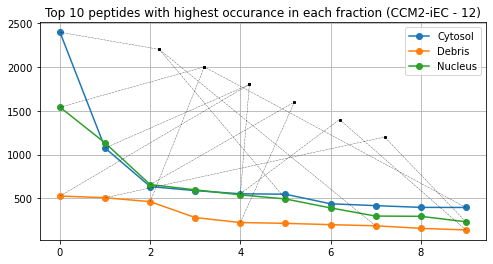

In [119]:
# peptide counts for each fraction in round 3 to see which fraction has the most peptides
ndf = mydf0[mydf0['round']=='3']
toppepcount = 10
for i, df in ndf.groupby(['cell_line','library']):
    print(i)
    cdf = pd.DataFrame()
    cdf2 = pd.DataFrame()
    plt.figure(figsize=(8,4))
    protlist = []
    for j, df2 in df.groupby('fraction'):
        #print(i,j)
        df2.sort_values('Count',ascending=False,inplace=True)
        df2.reset_index(drop=True,inplace=True)
        df2['rank'] = [w for w in range(len(df2))]
        dftoplt = df2[:10].copy()
        protlist += dftoplt['Protein'].tolist()
        plt.plot(dftoplt['Count'],label=j,marker='o')
        plt.legend()
        plt.grid()
        plt.title('Top {} peptides with highest occurance in each fraction ({} - {})'.format(toppepcount,i[0],i[1]))
        #df2.set_index('Protein')
        cdf = pd.concat([df2,cdf])
        cdf2 = pd.concat([dftoplt,cdf2])
    
    if len(set(protlist)) < 30:
        gdf = cdf.groupby('Protein').agg(list)
        xdf = gdf.loc[list(set(protlist))]
        gdf2 = cdf2.groupby('Protein').agg(list)
        xdf2 = gdf2.loc[list(set(protlist))]
        xdf2['maxvals'] = [max(pc) for pc in xdf2['Count']]
        xdf2.sort_values('maxvals',ascending=False,inplace=True)
        xgain = 2.2
        ygain = 2200
        for p,d in xdf2.iterrows():
            if len(d['rank']) > 1:
                
                for xp,zp in zip(d['rank'],d['Count']):
                    plt.plot([xp,xgain],[zp,ygain],c='k',linestyle='-.',linewidth=0.3)
                    plt.plot([xgain],[ygain],c='k',marker='o',markersize=2)
                xgain += 1
                ygain -= 200
                    
        print(len(xdf))
        display(xdf[['Count','Percentage','fraction','seq_count','rank']])
    else: print('all unique proteins')
    plt.show()
    break